# Imports

In [55]:
# !pip install PyMuPDF 
# !pip install transformers torch
# !pip install --upgrade ipywidgets

In [56]:
import fitz  # PyMuPDF
import torch
import logging
import spacy
import os
import string
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, OneHotEncoder, StandardScaler
from scipy.sparse import hstack, csr_matrix
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel, TFAutoModel
from collections import Counter

# Loading Data

In [57]:
df = pd.read_csv('pre-processed data.csv').set_index(['article_id' , 'paragraph_id'], inplace=False)
df['pos_tags'] = df['pos_tags'].apply(ast.literal_eval)
df

original_text  \
article_id paragraph_id                                                      
1          1             Provincies willen aan de slag met versoepeling...   
           2             Het draait allemaal om de drempelwaarde voor e...   
           3             Met een hogere drempelwaarde zouden minder ver...   
           4             In het hoofdlijnenakkoord hebben de vier coali...   
           5             De ondergrens is al langer onderwerp van discu...   
...                                                                    ...   
118        2             Telgenkamp vestigt haar hoop voor de korte ter...   
119        1             Waarom verzekeraars inkomsten uit zwart werk w...   
120        1             Verzekeraar wil klant helpen met zorgbemiddeli...   
           2             Verzekeraar wil wachtende patiënt aan snelle z...   
           3             Zorgbemiddeling is geen wondermiddel, maar kan...   

                                                                      text  \
article_id paragraph_id                                                      
1          1             provincie willen slag versoepeling stikstofreg...   
           2             draaien allemaal drempelwaran stikstofvergunni...   
           3             hoog drempelwaard vergunning [NEWLINE] aangevo...   
           4             hoofdlijnenakkoord vier coalitiepartij afsprek...   
           5             ondergren lang onderwerp discussie huidig Nede...   
...                                                                    ...   
118        2             telgenkamp vestigen hoop kort termijn twee cru...   
119        1             verzekeraar inkomst zwart werk vergoeden [NEWL...   
120        1             verzekeraar klant helpen zorgbemiddeling [NEWL...   
           2             verzekeraar wachten patiënt snel zorg helpen [...   
           3             zorgbemiddeling wondermiddel helpen zeggen Haa...   

                                   group  \
article_id paragraph_id                    
1          1             Bouw & Vastgoed   
           2             Bouw & Vastgoed   
           3             Bouw & Vastgoed   
           4             Bouw & Vastgoed   
           5             Bouw & Vastgoed   
...                                  ...   
118        2                        Zorg   
119        1                        Zorg   
120        1                        Zorg   
           2                        Zorg   
           3                        Zorg   

                                                 text before lemmatization  \
article_id paragraph_id                                                      
1          1             provincies willen slag versoepeling stikstofre...   
           2             draait allemaal drempelwaarde stikstofvergunni...   
           3             hogere drempelwaarde vergunningen [NEWLINE] aa...   
           4             hoofdlijnenakkoord vier coalitiepartijen afges...   
           5             ondergrens langer onderwerp discussie huidige ...   
...                                                                    ...   
118        2             telgenkamp vestigt hoop korte termijn twee cru...   
119        1             verzekeraars inkomsten zwart werk vergoeden [N...   
120        1             verzekeraar klant helpen zorgbemiddeling [NEWL...   
           2             verzekeraar wachtende patiënt snelle zorg help...   
           3             zorgbemiddeling wondermiddel helpen zegt haarl...   

                                                                  pos_tags  
article_id paragraph_id                                                     
1          1             [(provincie, NOUN), (willen, VERB), (slag, NOU...  
           2             [(draaien, VERB), (allemaal, ADV), (drempelwar...  
           3             [(hoog, ADJ), (drempelwaard, NOUN), (vergunnin...  
           4             [(hoofdlijnenakkoord, PROPN), (vi

# POS-tags one-hot encoding & ngrams

In [58]:
def pos_to_features(pos_tags):
    """Convert list of (word, POS) tuples into a dictionary of POS tag counts."""
    pos_counts = Counter(tag for _, tag in pos_tags)
    return dict(pos_counts)

def pos_to_ngrams(pos_tags, n=2):
    """Convert a list of POS-tag tuples into n-gram strings."""
    pos_sequence = [tag for _, tag in pos_tags]  # Extract only POS tags
    ngrams = ['_'.join(pos_sequence[i:i+n]) for i in range(len(pos_sequence)-n+1)]
    return ' '.join(ngrams)  # Convert to space-separated string for TF-IDF

In [59]:
X = df[['text', 'pos_tags']].copy() # Testing on df

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["group"])

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split the data into text and POS-tags
X_train_text, X_train_pos = X_train['text'], X_train['pos_tags']
X_val_text, X_val_pos = X_val['text'], X_val['pos_tags']
X_test_text, X_test_pos = X_test['text'], X_test['pos_tags']

# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_text = vectorizer.fit_transform(X_train_text)
X_val_text = vectorizer.transform(X_val_text)
X_test_text = vectorizer.transform(X_test_text)

# Convert POS tags to feature dictionaries
X_train_pos_features = X_train_pos.apply(pos_to_features)
X_val_pos_features = X_val_pos.apply(pos_to_features)
X_test_pos_features = X_test_pos.apply(pos_to_features)

# Vectorize POS features (Fit on train, Transform on val/test)
pos_vectorizer = DictVectorizer(sparse=True)
X_train_pos = pos_vectorizer.fit_transform(X_train_pos_features)
X_val_pos = pos_vectorizer.transform(X_val_pos_features)
X_test_pos = pos_vectorizer.transform(X_test_pos_features)

# Scale POS features (Fit on train, Transform on val/test)
scaler = MaxAbsScaler()
X_train_pos = scaler.fit_transform(X_train_pos)
X_val_pos = scaler.transform(X_val_pos)
X_test_pos = scaler.transform(X_test_pos)

# Combine TF-IDF and POS tag features
X_train_combined = hstack([X_train_text, X_train_pos])
X_val_combined = hstack([X_val_text, X_val_pos])
X_test_combined = hstack([X_test_text, X_test_pos])

# Final shape check
print(f"Train shape: {X_train_combined.shape}, Validation shape: {X_val_combined.shape}, Test shape: {X_test_combined.shape}")

Train shape: (261, 6376), Validation shape: (56, 6376), Test shape: (57, 6376)


**Now let's test them on the data**

In [60]:
# Tune the depth of the Random Forest using the validation set
best_depth = None
best_score = 0
depths = [5, 10, 15, 20, 25, None]  # Different depths to test

for depth in depths:
    classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    classifier.fit(X_train_combined, y_train)
    val_score = classifier.score(X_val_combined, y_val)
    print(f"Depth: {depth}, Validation Score: {val_score}")
    if val_score > best_score:
        best_score = val_score
        best_depth = depth

print(f"\nBest Depth: {best_depth}, Best Validation Score: {best_score}")

# Train the final model using the best depth
final_classifier = RandomForestClassifier(max_depth=best_depth, random_state=42)
final_classifier.fit(X_train_combined, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_combined)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Depth: 5, Validation Score: 0.5714285714285714
Depth: 10, Validation Score: 0.6607142857142857
Depth: 15, Validation Score: 0.6607142857142857
Depth: 20, Validation Score: 0.7142857142857143
Depth: 25, Validation Score: 0.6964285714285714
Depth: None, Validation Score: 0.6607142857142857

Best Depth: 20, Best Validation Score: 0.7142857142857143

Test Accuracy: 0.5614035087719298

Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.45      0.59      0.51        17
           2       0.36      0.40      0.38        10
           3       0.60      0.33      0.43         9

    accuracy                           0.56        57
   macro avg       0.55      0.51      0.52        57
weighted avg       0.58      0.56      0.56        57



In [61]:
best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_combined, y_train)
        val_score = classifier.score(X_val_combined, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_combined, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_combined)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Kernel: linear, C: 0.1, Validation Score: 0.4642857142857143
Kernel: linear, C: 1, Validation Score: 0.7321428571428571
Kernel: linear, C: 10, Validation Score: 0.75
Kernel: rbf, C: 0.1, Validation Score: 0.42857142857142855
Kernel: rbf, C: 1, Validation Score: 0.5178571428571429
Kernel: rbf, C: 10, Validation Score: 0.6964285714285714
Kernel: poly, C: 0.1, Validation Score: 0.48214285714285715
Kernel: poly, C: 1, Validation Score: 0.5714285714285714
Kernel: poly, C: 10, Validation Score: 0.5892857142857143

Best Kernel: linear, Best C: 10, Best Validation Score: 0.75

Test Accuracy: 0.6666666666666666

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.67      0.72        21
           1       0.55      0.71      0.62        17
           2       0.70      0.70      0.70        10
           3       0.71      0.56      0.63         9

    accuracy                           0.67        57
   macro avg       0.68      0.66 

In [62]:
#Testing only text

best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_text, y_train)
        val_score = classifier.score(X_val_text, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_text, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_text)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Kernel: linear, C: 0.1, Validation Score: 0.375
Kernel: linear, C: 1, Validation Score: 0.8035714285714286
Kernel: linear, C: 10, Validation Score: 0.7678571428571429
Kernel: rbf, C: 0.1, Validation Score: 0.375
Kernel: rbf, C: 1, Validation Score: 0.6785714285714286
Kernel: rbf, C: 10, Validation Score: 0.7142857142857143
Kernel: poly, C: 0.1, Validation Score: 0.375
Kernel: poly, C: 1, Validation Score: 0.6071428571428571
Kernel: poly, C: 10, Validation Score: 0.6428571428571429

Best Kernel: linear, Best C: 1, Best Validation Score: 0.8035714285714286

Test Accuracy: 0.7719298245614035

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.74      0.82      0.78        17
           2       0.62      0.80      0.70        10
           3       0.86      0.67      0.75         9

    accuracy                           0.77        57
   macro avg       0.77      0.76      0.76     

**Now we test for pos_tag ngrams rather than one-hot encodings:**

In [63]:
# Testing for ngrams

X = df[['text', 'pos_tags']].copy() # Testing on df

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["group"])

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split the data into text and POS-tags
X_train_text, X_train_pos = X_train['text'], X_train['pos_tags']
X_val_text, X_val_pos = X_val['text'], X_val['pos_tags']
X_test_text, X_test_pos = X_test['text'], X_test['pos_tags']


# Split the data into text and POS-tags and construct ngrams
X_train_text, X_train_pos = X_train['text'], X_train['pos_tags'].apply(lambda x: pos_to_ngrams(x, n=2))
X_val_text, X_val_pos = X_val['text'], X_val['pos_tags'].apply(lambda x: pos_to_ngrams(x, n=2))
X_test_text, X_test_pos = X_test['text'], X_test['pos_tags'].apply(lambda x: pos_to_ngrams(x, n=2))



# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_text = vectorizer.fit_transform(X_train_text)
X_val_text = vectorizer.transform(X_val_text)
X_test_text = vectorizer.transform(X_test_text)

# Convert POS n-grams to TF-IDF
pos_vectorizer = TfidfVectorizer()
X_train_pos = pos_vectorizer.fit_transform(X_train_pos)
X_val_pos = pos_vectorizer.transform(X_val_pos)
X_test_pos = pos_vectorizer.transform(X_test_pos)

# Scale POS features (Fit on train, Transform on val/test)
scaler = MaxAbsScaler()
X_train_pos = scaler.fit_transform(X_train_pos)
X_val_pos = scaler.transform(X_val_pos)
X_test_pos = scaler.transform(X_test_pos)

# Combine TF-IDF and POS tag features
X_train_combined = hstack([X_train_text, X_train_pos])
X_val_combined = hstack([X_val_text, X_val_pos])
X_test_combined = hstack([X_test_text, X_test_pos])

# Final shape check
print(f"Train shape: {X_train_combined.shape}, Validation shape: {X_val_combined.shape}, Test shape: {X_test_combined.shape}")

Train shape: (261, 6514), Validation shape: (56, 6514), Test shape: (57, 6514)


In [64]:
# Tune the depth of the Random Forest using the validation set
best_depth = None
best_score = 0
depths = [5, 10, 15, 20, 25, None]  # Different depths to test

for depth in depths:
    classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    classifier.fit(X_train_combined, y_train)
    val_score = classifier.score(X_val_combined, y_val)
    print(f"Depth: {depth}, Validation Score: {val_score}")
    if val_score > best_score:
        best_score = val_score
        best_depth = depth

print(f"\nBest Depth: {best_depth}, Best Validation Score: {best_score}")

# Train the final model using the best depth
final_classifier = RandomForestClassifier(max_depth=best_depth, random_state=42)
final_classifier.fit(X_train_combined, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_combined)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Depth: 5, Validation Score: 0.5535714285714286
Depth: 10, Validation Score: 0.6071428571428571
Depth: 15, Validation Score: 0.6071428571428571
Depth: 20, Validation Score: 0.6071428571428571
Depth: 25, Validation Score: 0.625
Depth: None, Validation Score: 0.6428571428571429

Best Depth: None, Best Validation Score: 0.6428571428571429

Test Accuracy: 0.5964912280701754

Test Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.76      0.74        21
           1       0.52      0.65      0.58        17
           2       0.45      0.50      0.48        10
           3       0.67      0.22      0.33         9

    accuracy                           0.60        57
   macro avg       0.59      0.53      0.53        57
weighted avg       0.61      0.60      0.58        57



In [65]:
best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_combined, y_train)
        val_score = classifier.score(X_val_combined, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_combined, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_combined)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Kernel: linear, C: 0.1, Validation Score: 0.5178571428571429
Kernel: linear, C: 1, Validation Score: 0.5535714285714286
Kernel: linear, C: 10, Validation Score: 0.5714285714285714
Kernel: rbf, C: 0.1, Validation Score: 0.375
Kernel: rbf, C: 1, Validation Score: 0.5178571428571429
Kernel: rbf, C: 10, Validation Score: 0.5178571428571429
Kernel: poly, C: 0.1, Validation Score: 0.375
Kernel: poly, C: 1, Validation Score: 0.5178571428571429
Kernel: poly, C: 10, Validation Score: 0.5714285714285714

Best Kernel: linear, Best C: 10, Best Validation Score: 0.5714285714285714

Test Accuracy: 0.47368421052631576

Test Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.62      0.60        21
           1       0.47      0.47      0.47        17
           2       0.36      0.50      0.42        10
           3       0.25      0.11      0.15         9

    accuracy                           0.47        57
   macro avg       0.42      0.43

In [66]:
#Testing only text

best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_text, y_train)
        val_score = classifier.score(X_val_text, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_text, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_text)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Kernel: linear, C: 0.1, Validation Score: 0.375
Kernel: linear, C: 1, Validation Score: 0.8035714285714286
Kernel: linear, C: 10, Validation Score: 0.7678571428571429
Kernel: rbf, C: 0.1, Validation Score: 0.375
Kernel: rbf, C: 1, Validation Score: 0.6785714285714286
Kernel: rbf, C: 10, Validation Score: 0.7142857142857143
Kernel: poly, C: 0.1, Validation Score: 0.375
Kernel: poly, C: 1, Validation Score: 0.6071428571428571
Kernel: poly, C: 10, Validation Score: 0.6428571428571429

Best Kernel: linear, Best C: 1, Best Validation Score: 0.8035714285714286

Test Accuracy: 0.7719298245614035

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.74      0.82      0.78        17
           2       0.62      0.80      0.70        10
           3       0.86      0.67      0.75         9

    accuracy                           0.77        57
   macro avg       0.77      0.76      0.76     

# Overarching Function Testing

In [78]:
def evaluate_model(df: pd.DataFrame, Testing_ratio: float = 0.15, k_values: list = [2, 3, 5, 10, 20], 
                   embedding: str = "tf-idf", C_values: list = [0.1, 1, 10], kernel_values: list = ['linear', 'rbf', 'poly'],
                   pos: str = "none", ngram_size: int = 2):
    """
    Function to extract embeddings (TF-IDF or BERTje), perform classification with SVM hyperparameter tuning, and evaluate using k-fold cross-validation.

    Parameters:
        df (pd.DataFrame): Input dataframe with 'text', 'group', and 'pos_tags' columns.
        Testing_ratio (float): Test set ratio for holdout validation (if k=1).
        k_values (list): List of k values for k-fold cross-validation.
        embedding (str): Embedding type ("tf-idf" or "BERTje").
        C_values (list): List of C hyperparameter values for SVM.
        kernel_values (list): List of kernel types for SVM.
        pos (str): POS feature processing ("none", "one-hot", "ngram").
        ngram_size (int): Size of n-grams when pos="ngram".

    Returns:
        dict: Dictionary of accuracies for each k and best SVM hyperparameters.
    """

    # Convert labels to numeric format
    df["label"] = df["group"].astype("category").cat.codes  

    # ===========================
    # 1. Extract Features (TF-IDF or BERTje)
    # ===========================

    if embedding.lower() == "tf-idf":
        print("\nUsing TF-IDF Embeddings...")
        vectorizer = TfidfVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df["text"]).toarray()  # Convert sparse matrix to NumPy array

    elif embedding.lower() == "bertje":
        print("\nUsing BERTje Embeddings...")
        
        # Load BERTje model & tokenizer
        tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
        model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")
        model.eval()  # Set to evaluation mode

        # Function to extract BERTje embeddings (Mean Pooling)
        def get_bertje_embedding(text):
            with torch.no_grad():
                tokens = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
                output = model(**tokens)
                embeddings = output.last_hidden_state.mean(dim=1)  # Mean pooling
            return embeddings.squeeze().numpy()

        # Compute BERTje embeddings (without progress bar)
        embeddings = np.array([get_bertje_embedding(text) for text in df["text"]])

    else:
        raise ValueError("Invalid embedding type. Choose 'tf-idf' or 'BERTje'.")

    # ===========================
    # 2. Process POS Tags if Needed
    # ===========================

    if pos == "one-hot":
        print("\nUsing One-Hot Encoding for POS Tags...")

        # One-hot encoding POS tags
        def pos_to_features(pos_tags):
            """Convert list of (word, POS) tuples into a dictionary of POS tag counts."""
            pos_counts = Counter(tag for _, tag in pos_tags)
            return dict(pos_counts)

        # Convert to list of dictionaries
        pos_features = [pos_to_features(tags) for tags in df["pos_tags"]]
    
        # Convert list of dictionaries to Pandas DataFrame (fill missing tags with 0)
        pos_df = pd.DataFrame(pos_features).fillna(0)
    
        # Create OneHotEncoder
        encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
        pos_features_encoded = encoder.fit_transform(pos_df)
    
        # Scale the POS features
        scaler = StandardScaler()
        pos_features_scaled = scaler.fit_transform(pos_features_encoded)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse

        if not isinstance(pos_features_scaled, csr_matrix):  
            pos_features_scaled = csr_matrix(pos_features_scaled)  # Convert dense to sparse

        # Combine embeddings with POS features
        embeddings = hstack([embeddings, pos_features_scaled])

    elif pos == "ngram":
        print(f"\nUsing N-gram POS Features (n={ngram_size})...")

        # Function to convert POS tags to n-grams
        def pos_to_ngrams(pos_tags, n=2):
            """Convert a list of POS-tag tuples into n-gram strings."""
            pos_sequence = [tag for _, tag in pos_tags]  # Extract only POS tags
            ngrams = ['_'.join(pos_sequence[i:i+n]) for i in range(len(pos_sequence)-n+1)]
            return ' '.join(ngrams)  # Convert to space-separated string for TF-IDF

        # Create POS n-grams
        pos_ngrams = np.array([pos_to_ngrams(tags, ngram_size) for tags in df["pos_tags"]])

        # Use TF-IDF to extract n-gram features
        vectorizer = TfidfVectorizer(max_features=1000)  # Use fewer features since it's for POS
        pos_embeddings = vectorizer.fit_transform(pos_ngrams).toarray()

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse

        if not isinstance(pos_embeddings, csr_matrix):  
            pos_embeddings = csr_matrix(pos_embeddings)  # Convert dense to sparse
        
        # Combine embeddings with POS n-grams features
        embeddings = hstack([embeddings, pos_embeddings])

    elif pos != "none":
        raise ValueError("Invalid POS type. Choose 'none', 'one-hot', or 'ngram'.")

    # ===========================
    # 3. Model Evaluation (Holdout or k-Fold) with Hyperparameter Search
    # ===========================

    best_k = None
    best_accuracy = 0
    best_params = None
    results = {}

    for k in k_values:
        print(f"\nEvaluating k={k}-Fold Cross-Validation..." if k > 1 else "\nPerforming Holdout Validation (k=1)...")
        
        accuracy_scores = []
        best_C, best_kernel = None, None

        if k == 1:
            # Holdout validation (80% Train, 20% Test)
            X_train, X_val, y_train, y_val = train_test_split(
                embeddings, df["label"], test_size=Testing_ratio, stratify=df["label"], random_state=42
            )

            # Hyperparameter tuning for SVM
            for C in C_values:
                for kernel in kernel_values:
                    classifier = SVC(kernel=kernel, C=C)
                    classifier.fit(X_train, y_train)
                    y_pred = classifier.predict(X_val)
                    accuracy = accuracy_score(y_val, y_pred)

                    print(f"C: {C}, Kernel: {kernel}, Accuracy: {accuracy:.4f}")

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_C, best_kernel = C, kernel

            # Train best model on holdout set
            classifier = SVC(kernel=best_kernel, C=best_C)
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_val)
            accuracy_scores.append(accuracy_score(y_val, y_pred))

        else:
            # Perform k-fold cross-validation
            kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

            for train_index, val_index in kf.split(embeddings, df["label"]):
                X_train, X_val = embeddings[train_index], embeddings[val_index]
                y_train, y_val = df["label"].iloc[train_index].values, df["label"].iloc[val_index].values

                # Hyperparameter tuning for SVM
                best_fold_accuracy = 0
                for C in C_values:
                    for kernel in kernel_values:
                        classifier = SVC(kernel=kernel, C=C)
                        classifier.fit(X_train, y_train)
                        y_pred = classifier.predict(X_val)
                        accuracy = accuracy_score(y_val, y_pred)

                        if accuracy > best_fold_accuracy:
                            best_fold_accuracy = accuracy
                            best_C, best_kernel = C, kernel

                # Train best model for this fold
                classifier = SVC(kernel=best_kernel, C=best_C)
                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_val)
                accuracy_scores.append(accuracy_score(y_val, y_pred))

        # Compute mean accuracy for this k
        mean_accuracy = np.mean(accuracy_scores)
        results[k] = {"accuracy": mean_accuracy, "best_C": best_C, "best_kernel": best_kernel}

        print(f"Best SVM Params for k={k}: C={best_C}, Kernel={best_kernel}, Mean Accuracy: {mean_accuracy:.4f}")

        # Track best k and parameters

In [16]:
evaluate_model(df, Testing_ratio = 0.15, k_values = [2, 3, 5, 10, 20], 
                   embedding = "tf-idf", C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...

Evaluating k=2-Fold Cross-Validation...
Best SVM Params for k=2: C=10, Kernel=linear, Mean Accuracy: 0.6765

Evaluating k=3-Fold Cross-Validation...
Best SVM Params for k=3: C=1, Kernel=linear, Mean Accuracy: 0.6926

Evaluating k=5-Fold Cross-Validation...
Best SVM Params for k=5: C=1, Kernel=linear, Mean Accuracy: 0.6927

Evaluating k=10-Fold Cross-Validation...
Best SVM Params for k=10: C=1, Kernel=linear, Mean Accuracy: 0.7061

Evaluating k=20-Fold Cross-Validation...
Best SVM Params for k=20: C=1, Kernel=linear, Mean Accuracy: 0.7120


In [34]:
evaluate_model(df, Testing_ratio = 0.15, k_values = [1, 2, 5], 
                   embedding = "tf-idf", C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...

Performing Holdout Validation (k=1)...
C: 0.1, Kernel: linear, Accuracy: 0.3333
C: 0.1, Kernel: rbf, Accuracy: 0.3333
C: 0.1, Kernel: poly, Accuracy: 0.3333
C: 1, Kernel: linear, Accuracy: 0.7719
C: 1, Kernel: rbf, Accuracy: 0.6140
C: 1, Kernel: poly, Accuracy: 0.4386
C: 10, Kernel: linear, Accuracy: 0.7193
C: 10, Kernel: rbf, Accuracy: 0.6491
C: 10, Kernel: poly, Accuracy: 0.4386
Best SVM Params for k=1: C=1, Kernel=linear, Mean Accuracy: 0.7719

Evaluating k=2-Fold Cross-Validation...
Best SVM Params for k=2: C=10, Kernel=linear, Mean Accuracy: 0.6765

Evaluating k=5-Fold Cross-Validation...
Best SVM Params for k=5: C=1, Kernel=linear, Mean Accuracy: 0.6927


In [74]:
evaluate_model(df, Testing_ratio = 0.15, k_values = [1, 2, 3, 5, 10], 
                   embedding = "tf-idf", C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   pos = "one-hot", ngram_size = 2)


Using TF-IDF Embeddings...

Using One-Hot Encoding for POS Tags...

Performing Holdout Validation (k=1)...


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


C: 0.1, Kernel: linear, Accuracy: 0.3509
C: 0.1, Kernel: rbf, Accuracy: 0.3333
C: 0.1, Kernel: poly, Accuracy: 0.3333
C: 1, Kernel: linear, Accuracy: 0.3509
C: 1, Kernel: rbf, Accuracy: 0.4035
C: 1, Kernel: poly, Accuracy: 0.3333
C: 10, Kernel: linear, Accuracy: 0.3509
C: 10, Kernel: rbf, Accuracy: 0.3333
C: 10, Kernel: poly, Accuracy: 0.3158
Best SVM Params for k=1: C=1, Kernel=rbf, Mean Accuracy: 0.4035

Evaluating k=2-Fold Cross-Validation...
Best SVM Params for k=2: C=10, Kernel=rbf, Mean Accuracy: 0.4733

Evaluating k=3-Fold Cross-Validation...
Best SVM Params for k=3: C=1, Kernel=rbf, Mean Accuracy: 0.4440

Evaluating k=5-Fold Cross-Validation...
Best SVM Params for k=5: C=1, Kernel=rbf, Mean Accuracy: 0.4412

Evaluating k=10-Fold Cross-Validation...
Best SVM Params for k=10: C=0.1, Kernel=linear, Mean Accuracy: 0.4336


In [75]:
evaluate_model(df, Testing_ratio = 0.15, k_values = [1, 2, 3, 5, 10], 
                   embedding = "bertje", C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   pos = "one-hot", ngram_size = 2)


Using BERTje Embeddings...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using One-Hot Encoding for POS Tags...

Performing Holdout Validation (k=1)...


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


C: 0.1, Kernel: linear, Accuracy: 0.4912
C: 0.1, Kernel: rbf, Accuracy: 0.3333
C: 0.1, Kernel: poly, Accuracy: 0.3333
C: 1, Kernel: linear, Accuracy: 0.4912
C: 1, Kernel: rbf, Accuracy: 0.4386
C: 1, Kernel: poly, Accuracy: 0.3860
C: 10, Kernel: linear, Accuracy: 0.4912
C: 10, Kernel: rbf, Accuracy: 0.4737
C: 10, Kernel: poly, Accuracy: 0.3860
Best SVM Params for k=1: C=0.1, Kernel=linear, Mean Accuracy: 0.4912

Evaluating k=2-Fold Cross-Validation...
Best SVM Params for k=2: C=10, Kernel=rbf, Mean Accuracy: 0.5160

Evaluating k=3-Fold Cross-Validation...
Best SVM Params for k=3: C=10, Kernel=rbf, Mean Accuracy: 0.5028

Evaluating k=5-Fold Cross-Validation...
Best SVM Params for k=5: C=0.1, Kernel=linear, Mean Accuracy: 0.4947

Evaluating k=10-Fold Cross-Validation...
Best SVM Params for k=10: C=0.1, Kernel=linear, Mean Accuracy: 0.5112


In [79]:
evaluate_model(df, Testing_ratio = 0.15, k_values = [1, 2, 3, 5, 10, 20], 
                   embedding = "tf-idf", C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   pos = "ngram", ngram_size = 2)


Using TF-IDF Embeddings...

Using N-gram POS Features (n=2)...

Performing Holdout Validation (k=1)...
C: 0.1, Kernel: linear, Accuracy: 0.3333
C: 0.1, Kernel: rbf, Accuracy: 0.3333
C: 0.1, Kernel: poly, Accuracy: 0.3333
C: 1, Kernel: linear, Accuracy: 0.7368
C: 1, Kernel: rbf, Accuracy: 0.5263
C: 1, Kernel: poly, Accuracy: 0.4912
C: 10, Kernel: linear, Accuracy: 0.6316
C: 10, Kernel: rbf, Accuracy: 0.7018
C: 10, Kernel: poly, Accuracy: 0.5965
Best SVM Params for k=1: C=1, Kernel=linear, Mean Accuracy: 0.7368

Evaluating k=2-Fold Cross-Validation...
Best SVM Params for k=2: C=1, Kernel=linear, Mean Accuracy: 0.6257

Evaluating k=3-Fold Cross-Validation...
Best SVM Params for k=3: C=1, Kernel=linear, Mean Accuracy: 0.6525

Evaluating k=5-Fold Cross-Validation...
Best SVM Params for k=5: C=1, Kernel=linear, Mean Accuracy: 0.6739

Evaluating k=10-Fold Cross-Validation...
Best SVM Params for k=10: C=1, Kernel=linear, Mean Accuracy: 0.6847

Evaluating k=20-Fold Cross-Validation...
Best SVM

In [80]:
evaluate_model(df, Testing_ratio = 0.15, k_values = [1, 2, 3, 5, 10, 20], 
                   embedding = "bertje", C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   pos = "ngram", ngram_size = 2)


Using BERTje Embeddings...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using N-gram POS Features (n=2)...

Performing Holdout Validation (k=1)...
C: 0.1, Kernel: linear, Accuracy: 0.7368
C: 0.1, Kernel: rbf, Accuracy: 0.3333
C: 0.1, Kernel: poly, Accuracy: 0.4211
C: 1, Kernel: linear, Accuracy: 0.7018
C: 1, Kernel: rbf, Accuracy: 0.5789
C: 1, Kernel: poly, Accuracy: 0.6316
C: 10, Kernel: linear, Accuracy: 0.6842
C: 10, Kernel: rbf, Accuracy: 0.7544
C: 10, Kernel: poly, Accuracy: 0.7368
Best SVM Params for k=1: C=10, Kernel=rbf, Mean Accuracy: 0.7544

Evaluating k=2-Fold Cross-Validation...
Best SVM Params for k=2: C=0.1, Kernel=linear, Mean Accuracy: 0.7059

Evaluating k=3-Fold Cross-Validation...
Best SVM Params for k=3: C=10, Kernel=poly, Mean Accuracy: 0.7033

Evaluating k=5-Fold Cross-Validation...
Best SVM Params for k=5: C=0.1, Kernel=linear, Mean Accuracy: 0.7273

Evaluating k=10-Fold Cross-Validation...
Best SVM Params for k=10: C=10, Kernel=rbf, Mean Accuracy: 0.7193

Evaluating k=20-Fold Cross-Validation...
Best SVM Params for k=20: C=10, Kerne

In [17]:
# To Do:

# Test all possible parameter values and find best model
# Add parameter for max-pooling, mean-pooling and min-pooling for BERTje embeddings
# Test for RF and Multinomial naive bayes (Gaussian naive bayes if you have continuous features due to using pos)

# SVM Model Functions

In [13]:
def Tune_SVM_tfidf_no_POS(df: pd.DataFrame,
                          testing_ratio: float = 0.15, 
                          k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the SVM classifier using stratified K-fold cross validation
    best_kernel = None
    best_C = None
    best_k = None
    best_score = 0
    
    kernels = ['linear', 'rbf', 'poly']
    C_values = [0.1, 1, 10]

    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for C in C_values:
                for kernel in kernels:
                    classifier = SVC(kernel=kernel, C=C, random_state=42)
                    classifier.fit(X_train_tfidf, y_train)
                    y_pred = classifier.predict(X_val_tfidf)
                    mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                    print(f"K: {k}, C: {C}, Kernel: {kernel}, tf-idf, no POS, Validation Accuracy: {mean_score}")
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_C = C
                        best_kernel = kernel
                        best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
            
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for C in C_values:
            for kernel in kernels:
                scores = []
                
                for train_index, val_index in skf.split(X_train_tfidf, y_train):
                    X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                
                classifier = SVC(kernel=kernel, C=C, random_state=42)
                classifier.fit(X_train_fold, y_train_fold)
                y_pred = classifier.predict(X_val_fold)
                        
                scores.append(accuracy_score(y_val_fold, y_pred))
                
                mean_score = np.mean(scores)
                print(f"K: {k}, C: {C}, Kernel: {kernel}, StratifiedKFold Score: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_C = C
                    best_kernel = kernel
                    best_k = k
    
    print(f"\nBest K: {best_k}, Best C: {best_C}, Best kernel: {best_kernel}, Best StratifiedKFold Score: {best_score}")
        
    final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_C, best_kernel, y_pred
    

In [14]:
Tune_SVM_tfidf_no_POS(df,
                     k_values = [1,2,3,4,5])

K: 1, C: 0.1, Kernel: linear, tf-idf, no POS, Validation Accuracy: 0.375
K: 1, C: 0.1, Kernel: rbf, tf-idf, no POS, Validation Accuracy: 0.375
K: 1, C: 0.1, Kernel: poly, tf-idf, no POS, Validation Accuracy: 0.375
K: 1, C: 1, Kernel: linear, tf-idf, no POS, Validation Accuracy: 0.8035714285714286
K: 1, C: 1, Kernel: rbf, tf-idf, no POS, Validation Accuracy: 0.6785714285714286
K: 1, C: 1, Kernel: poly, tf-idf, no POS, Validation Accuracy: 0.6071428571428571
K: 1, C: 10, Kernel: linear, tf-idf, no POS, Validation Accuracy: 0.7678571428571429
K: 1, C: 10, Kernel: rbf, tf-idf, no POS, Validation Accuracy: 0.7142857142857143
K: 1, C: 10, Kernel: poly, tf-idf, no POS, Validation Accuracy: 0.6428571428571429
K: 2, C: 0.1, Kernel: linear, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 0.1, Kernel: rbf, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 0.1, Kernel: poly, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 1, Kernel: linear, StratifiedKFold Score: 0.6455696202531646
K: 2,

(SVC(C=1, kernel='linear', random_state=42),
 1,
 1,
 'linear',
 array(['Bouw & Vastgoed', 'Zorg', 'Bouw & Vastgoed', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Zorg', 'Zakelijke Dienstverlening',
        'Handel & Industrie', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Bouw & Vastgoed',
        'Zakelijke Dienstverlening', 'Bouw & Vastgoed', 'Bouw & Vastgoed',
        'Zakelijke Dienstverlening', 'Handel & Industrie',
        'Handel & Industrie', 'Bouw & Vastgoed', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Handel & Industrie',
        'Bouw & Vastgoed', 'Handel & Industrie', 'Zorg', 'Bouw & Vastgoed',
        'Bouw & Vastgoed', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Zorg', 'Bouw & Vastgoed',
        'Zakelijke Dienstverlening', 'Handel & Industrie',
        'Handel & Industrie', 'Zakelijke Dienstverlening',
        'Handel & Industrie', 'Zakelijke Dienstverlening',
        'Bouw & Vastgoed', 'Handel & Industrie',

In [28]:
def get_bertje_embedding(text, tokenizer, model):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=64, return_tensors="pt") # Set max_length to 256 after testing
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token representation
    
def Tune_SVM_no_POS(df: pd.DataFrame,
                    testing_ratio: float = 0.15, 
                    embedding: str = "tf-idf",
                    k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the SVM classifier using stratified K-fold cross validation
    best_kernel = None
    best_C = None
    best_k = None
    best_score = 0
    
    kernels = ['linear', 'rbf', 'poly']
    C_values = [0.1, 1, 10]

    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column

    if embedding == "tf-idf":
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_ratio, random_state=42, stratify=y)
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        
    elif embedding == "BERTje":
        MODEL_NAME = "GroNLP/bert-base-dutch-cased"
        tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
        model = BertModel.from_pretrained(MODEL_NAME)

        BERTje_embeddings = np.array([get_bertje_embedding(text, tokenizer, model) for text in df["text"]])
        
        # X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y.tolist(), test_size=testing_ratio, random_state=42, stratify=y)
        # X_train = torch.stack([torch.tensor(get_bertje_embedding(text, tokenizer, model)) for text in X_train]).numpy()
        # # X_val = torch.stack([torch.tensor(get_bertje_embedding(text, tokenizer, model)) for text in X_val]).numpy()
        # X_test = torch.stack([torch.tensor(get_bertje_embedding(text, tokenizer, model)) for text in X_test]).numpy()
    
    # Try different hyperparameter combinations
    for k in k_values:
        
        if k == 1: # If k=1, we use standard hold-out cross-validation
            if embedding == "tf-idf":
                X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42, stratify=y) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
                X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
                
                vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
                X_train = vectorizer.fit_transform(X_train)
                X_val = vectorizer.transform(X_val)
                X_test = vectorizer.transform(X_test)
                
            elif embedding == "BERTje":
                X_train, X_temp, y_train, y_temp = train_test_split(BERTje_embeddings, y, test_size=testing_ratio*2, random_state=42, stratify=y)
                X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            for C in C_values:
                for kernel in kernels:
                    classifier = SVC(kernel=kernel, C=C, random_state=42)
                    classifier.fit(X_train, y_train)
                    y_pred = classifier.predict(X_val)
                    mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                    print(f"K: {k}, C: {C}, Kernel: {kernel}, tf-idf, no POS, Validation Accuracy: {mean_score}")
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_C = C
                        best_kernel = kernel
                        best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train = vectorizer.fit_transform(X_train)
            X_test = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
            
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for C in C_values:
            for kernel in kernels:
                scores = []
                
                for train_index, val_index in skf.split(X_train, y_train):
                    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                
                classifier = SVC(kernel=kernel, C=C, random_state=42)
                classifier.fit(X_train_fold, y_train_fold)
                y_pred = classifier.predict(X_val_fold)
                        
                scores.append(accuracy_score(y_val_fold, y_pred))
                
                mean_score = np.mean(scores)
                print(f"K: {k}, C: {C}, Kernel: {kernel}, StratifiedKFold Score: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_C = C
                    best_kernel = kernel
                    best_k = k
    
    print(f"\nBest K: {best_k}, Best C: {best_C}, Best kernel: {best_kernel}, Best StratifiedKFold Score: {best_score}")
        
    final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
    final_classifier.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_C, best_kernel, y_pred
    

In [16]:
Tune_SVM_no_POS(df, embedding="BERTje")

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'list' object has no attribute 'iloc'

In [29]:
Tune_SVM_no_POS(df, embedding="BERTje", k_values=[1])

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


K: 1, C: 0.1, Kernel: linear, tf-idf, no POS, Validation Accuracy: 0.5714285714285714
K: 1, C: 0.1, Kernel: rbf, tf-idf, no POS, Validation Accuracy: 0.32142857142857145
K: 1, C: 0.1, Kernel: poly, tf-idf, no POS, Validation Accuracy: 0.32142857142857145
K: 1, C: 1, Kernel: linear, tf-idf, no POS, Validation Accuracy: 0.5714285714285714
K: 1, C: 1, Kernel: rbf, tf-idf, no POS, Validation Accuracy: 0.5178571428571429
K: 1, C: 1, Kernel: poly, tf-idf, no POS, Validation Accuracy: 0.5535714285714286
K: 1, C: 10, Kernel: linear, tf-idf, no POS, Validation Accuracy: 0.5714285714285714
K: 1, C: 10, Kernel: rbf, tf-idf, no POS, Validation Accuracy: 0.625
K: 1, C: 10, Kernel: poly, tf-idf, no POS, Validation Accuracy: 0.6071428571428571


UnboundLocalError: local variable 'vectorizer' referenced before assignment

# RF Model Functions

# NB Model Functions

Since the process of tuning a classifier tends to not change much, we create a function for every type of classifier so that we can tune them without needing to re-write the code every time.

In [115]:
def tune_naive_bayes(df: pd.DataFrame,
                     testing_ratio: float = 0.15, 
                     vectorization_within_folds: bool = False,
                     k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the SVM classifier using stratified K-fold cross validation
    best_alpha = None
    best_fit_prior = None
    best_score = 0
    
    alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    fit_prior_values = [True, False]  

    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    if not vectorization_within_folds:
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for alpha in alpha_values:
                for fit_prior_value in fit_prior_values:
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_tfidf, y_train)
                    y_pred = classifier.predict(X_val_tfidf)
                    mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                    print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, Validation Accuracy: {mean_score}")
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_alpha = alpha
                        best_fit_prior = fit_prior_value
                        best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
            
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for alpha in alpha_values:
            for fit_prior_value in fit_prior_values:
                scores = []
    
                if vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train, y_train):
                        # Split the raw text data for the current fold
                        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
                    vectorizer = TfidfVectorizer(max_features=10000)
                    X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                    X_val_fold_tfidf = vectorizer.transform(X_val_fold)
    
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_fold_tfidf, y_train_fold)
                    y_pred = classifier.predict(X_val_fold_tfidf)
    
                if not vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train_tfidf, y_train):
                        X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                    
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_fold, y_train_fold)
                    y_pred = classifier.predict(X_val_fold)
                        
                scores.append(accuracy_score(y_val_fold, y_pred))
                
                mean_score = np.mean(scores)
                print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, StratifiedKFold Score: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_alpha = alpha
                    best_fit_prior = fit_prior_value
                    best_k = k
    
    print(f"\nBest K: {best_k}, Best alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best StratifiedKFold Score: {best_score}")
    
    # Train the final model using the best hyperparameters
    if vectorization_within_folds: # X_train_tfidf has yet to be calculated in this case
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
    final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    # y_pred_prob = final_classifier.predict_proba(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_alpha, best_fit_prior, y_pred

In [116]:
def tune_random_forest(df: pd.DataFrame,
                       testing_ratio: float = 0.15, 
                       vectorization_within_folds: bool = False,
                       k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the Random Forest using stratified K-fold cross validation
    best_depth = None
    best_score = 0
    depth_values = [5, 10, 15, 20, 25, None]  # Different depths to test
    # depth_values = [5, 10]  # For faster tests
    
    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    if not vectorization_within_folds:
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for depth in depth_values:
                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_tfidf, y_train)
                y_pred = classifier.predict(X_val_tfidf)
                mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                print(f"K: {k}, Depth: {depth}, Validation Accuracy: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_depth = depth
                    best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
        
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for depth in depth_values:
            scores = []

            if vectorization_within_folds:
                for train_index, val_index in skf.split(X_train, y_train):
                    # Split the raw text data for the current fold
                    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                vectorizer = TfidfVectorizer(max_features=10000)
                X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                X_val_fold_tfidf = vectorizer.transform(X_val_fold)

                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_fold_tfidf, y_train_fold)
                y_pred = classifier.predict(X_val_fold_tfidf)

            if not vectorization_within_folds:
                for train_index, val_index in skf.split(X_train_tfidf, y_train):
                    X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                
                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_fold, y_train_fold)
                y_pred = classifier.predict(X_val_fold)
                    
            scores.append(accuracy_score(y_val_fold, y_pred))
            
            mean_score = np.mean(scores)
            print(f"K: {k}, Depth: {depth}, StratifiedKFold Score: {mean_score}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_depth = depth
                best_k = k
    
    print(f"\nBest K: {best_k}, Best depth: {best_depth}, Best StratifiedKFold Score: {best_score}")
    
    # Train the final model using the best hyperparameters
    if vectorization_within_folds: # X_train_tfidf has yet to be calculated in this case
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
    final_classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    # y_pred_prob = final_classifier.predict_proba(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_depth, y_pred

# Overarching Model Tuning Function

Expected parameter values: <br>
> - _classifier_: Selects the type of classifier from amongst the following: ["SVM", "NB", "RF"].
> - _embedding_: Selects the type of word embedding from amongst the following: ["tf-idf", "BERTje"].
> - _pos_: Selects how POS tags are used from amongst the following: ["none", "one-hot", "ngram"].
> - _n_: Selects the type of ngrams that are used. Must be an integer, no smaller than 2.
> > Note that if _pos_$\neq$"ngram", n is not used and its value is irrelevant.
> - _testing_ratio_: The ratio of the data that is reserved for testing. Any floating point in the inclusive interval [0, 1].
> > Note that if $k=1$, the size of the validation set is assumed to be equal to the size of the testing set, specified by _testing_ratio_.
> - _vectorization_within_folds_: Would you like to vectorize each individual fold rather than vectorizing the entire training set once? [True, False].
> - _show_class_accuracy_: Would you like the accuracy per class to be displayed? [True, False].
> - _show_confusion_matrix_: Would you like the resulting confusion matrix to be displayed? [True, False].
> - _k_values_: All values of k which are tested for stratified k-fold cross validation. Any list containing only positive integers.
> > Note that if _pos_$\neq$"none", standard holdout cross-validation is performed, meaning that _k_values_ is irrelevant since only $k=1$ is used.

In [117]:
def train_model(df: pd.DataFrame,
                model_type: str = "SVM", 
                embedding: str = "tf-idf",
                pos: str = "none",
                n: list = [2,3,4,5],
                testing_ratio: float = 0.15, 
                vectorization_within_folds: bool = False, 
                show_class_accuracy: bool = True, 
                show_confusion_matrix: bool = True,
                k_values: list = [2, 3, 5, 10, 20],):
    """..."""

    print(f"Tuning {model_type} classifier with a train/test split of {1-testing_ratio}/{testing_ratio} \n")
    
    #Raise appropriate error message in case of a faulty parameter value
    if not isinstance(df, pd.DataFrame):
        raise ValueError(f"Invalid input data. Please ensure df is a Pandas DataFrame")
    if model_type not in ["SVM", "NB", "RF"]:
        raise ValueError(f"Invalid model_type. Choose from {'SVM', 'NB', 'RF'}")
    if testing_ratio < 0 or testing_ratio > 1:
        raise ValueError(f"Invalid testing ratio. Choose a value in the inclusive interval [0,1]")
    if type(vectorization_within_folds) != bool:
        raise ValueError(f"Invalid vectorization_within_folds value. Please ensure vectorization_within_folds is boolean")
    if type(show_class_accuracy) != bool:
        raise ValueError(f"Invalid show_class_accuracy value. Please ensure show_class_accuracy is boolean")
    if type(show_confusion_matrix) != bool:
        raise ValueError(f"Invalid show_confusion_matrix value. Please ensure show_confusion_matrix is boolean")
    if not all(isinstance(x, int) and x > 0 for x in k_values):
        raise ValueError(f"Invalid k_values. Please ensure all entries in k_values are positive integers")
    if 1 in k_values and vectorization_within_folds:
        raise ValueError(f"If k_values contains 1, vectorization_within_folds must be False since k=1 implies standard hold-out cross-validation, for which vectorization_within_folds must be False")
    if embedding not in ["tf-idf", "BERTje"]:
        raise ValueError(f'Invalid embedding. Choose from ["tf-idf", "BERTje"]')
    if pos not in ["none", "one-hot", "ngram"]:
        raise ValueError(f'Invalid pos. Choose from ["none", "one-hot", "ngram"]')
    if type(n) != int or n < 2:
        raise ValueError(f"Invalid n value. Please ensure n is an integer, no smaller than 2")

    model_mapping = {"SVM": SVC, "NB": MultinomialNB , "RF": RandomForestClassifier}
    ModelClass = model_mapping[model_type]
    
    #Best classifier performance and number of stratified folds so far
    best_score = 0
    best_k = None

    #RF hyperparameters:
    best_depth = None
    depth_values = [5, 10, 15, 20, 25, None]

    #SVM hyperparameters:
    best_kernel = None
    best_C = None
    kernel_values = ['linear', 'rbf', 'poly']
    C_values = [0.1, 1, 10]

    #NB hyperparameters:
    best_alpha = None
    best_fit_prior = None
    alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    fit_prior_values = [True, False]
    
    if model_type == "SVM":
        results = tune_SVM(df=df, testing_ratio=testing_ratio, 
                           vectorization_within_folds=vectorization_within_folds, 
                           k_values=k_values, 
                           embedding=embedding, 
                           pos=pos, 
                           n=n)
        classifier, y_test, y_pred = results[0], results[4], results[5]

    if model_type == "NB":
        results = tune_naive_bayes(df=df, 
                                   testing_ratio=testing_ratio, 
                                   vectorization_within_folds=vectorization_within_folds, 
                                   k_values=k_values,
                                   embedding=embedding,
                                   pos=pos,
                                   n=n)
        classifier, y_pred = results[0], results[4]

    if model_type == "RF":
        results = tune_random_forest(df=df, 
                                     testing_ratio=testing_ratio, 
                                     vectorization_within_folds=vectorization_within_folds, 
                                     k_values=k_values, 
                                     embedding=embedding,
                                     pos=pos,
                                     n=n)
        classifier, y_pred = results[0], results[3]
    
    if show_class_accuracy:
        cm = confusion_matrix(y_test, y_pred)
        
        # Class names (assuming they are in the same order as in y_train or y_test)
        class_names = np.unique(y_test)  # This will give you the unique class labels
        
        # Calculate per-class accuracy: TP / (TP + FN)
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        
        # Print the accuracy for each class along with its name
        for i, acc in enumerate(class_accuracies):
            print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

    if show_confusion_matrix:
              
        cm = confusion_matrix(y_test, y_pred)
        class_names = np.unique(y_test)
        
        # Plotting the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
        
        # Label the axes
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        # Display the plot
        plt.show()

# Testing Overarching Function

In [118]:
train_model(df=df,
            model_type = "SVM", 
            embedding = "tf-idf",
            pos = "one-hot",
            n = 2,
            testing_ratio = 0.15, 
            vectorization_within_folds = True, 
            show_class_accuracy = True, 
            show_confusion_matrix = True,
           k_values = [2,12,15])

Tuning SVM classifier with a train/test split of 0.85/0.15 

K: 2, C: 0.1, Kernel: linear, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.4642857142857143
K: 2, C: 0.1, Kernel: rbf, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.42857142857142855
K: 2, C: 0.1, Kernel: poly, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.48214285714285715
K: 2, C: 1, Kernel: linear, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.7321428571428571
K: 2, C: 1, Kernel: rbf, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.5178571428571429
K: 2, C: 1, Kernel: poly, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.5714285714285714
K: 2, C: 10, Kernel: linear, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.75
K: 2, C: 10, Kernel: rbf, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.6964285714285714
K: 2, C: 10, Kernel: poly, Embedding: tf-idf, POS: one-hot, Validation Accuracy: 0.5892857142857143
article_id  paragraph_id
17          3          

ValueError: Found input variables with inconsistent numbers of samples: [57, 56]

In [121]:
Tune_SVM_tfidf_no_POS(df=df,
                      testing_ratio = 0.15, 
                      vectorization_within_folds = True, 
                      k_values = [2,12,15])

K: 2, C: 0.1, Kernel: linear, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 0.1, Kernel: rbf, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 0.1, Kernel: poly, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 1, Kernel: linear, StratifiedKFold Score: 0.6329113924050633
K: 2, C: 1, Kernel: rbf, StratifiedKFold Score: 0.5
K: 2, C: 1, Kernel: poly, StratifiedKFold Score: 0.5126582278481012
K: 2, C: 10, Kernel: linear, StratifiedKFold Score: 0.6708860759493671
K: 2, C: 10, Kernel: rbf, StratifiedKFold Score: 0.620253164556962
K: 2, C: 10, Kernel: poly, StratifiedKFold Score: 0.5316455696202531
K: 12, C: 0.1, Kernel: linear, StratifiedKFold Score: 0.34615384615384615
K: 12, C: 0.1, Kernel: rbf, StratifiedKFold Score: 0.34615384615384615
K: 12, C: 0.1, Kernel: poly, StratifiedKFold Score: 0.34615384615384615
K: 12, C: 1, Kernel: linear, StratifiedKFold Score: 0.5384615384615384
K: 12, C: 1, Kernel: rbf, StratifiedKFold Score: 0.46153846153846156
K: 12, C: 1, Kernel: poly, Strat

(SVC(C=10, kernel='linear', random_state=42),
 2,
 None,
 array(['Bouw & Vastgoed', 'Zorg', 'Bouw & Vastgoed', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Zorg', 'Zakelijke Dienstverlening',
        'Handel & Industrie', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Handel & Industrie',
        'Handel & Industrie', 'Zakelijke Dienstverlening',
        'Handel & Industrie', 'Handel & Industrie', 'Bouw & Vastgoed',
        'Handel & Industrie', 'Zakelijke Dienstverlening',
        'Handel & Industrie', 'Bouw & Vastgoed', 'Handel & Industrie',
        'Zorg', 'Handel & Industrie', 'Bouw & Vastgoed',
        'Handel & Industrie', 'Zakelijke Dienstverlening', 'Zorg',
        'Bouw & Vastgoed', 'Zakelijke Dienstverlening',
        'Handel & Industrie', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Handel & Industrie',
        'Zakelijke Dienstverlening', 'Handel & Industrie',
        'Hand

# Vector Transformation

For now, I only test TF-IDF

In [98]:
# Extract features and labels
X = df_clean['text']  # Feature: text column
y = df_clean['group']  # Label: group column

In [99]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [100]:
# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [101]:
X_train_tfidf

<261x6360 sparse matrix of type '<class 'numpy.float64'>'
	with 19093 stored elements in Compressed Sparse Row format>

In [102]:
X_val_tfidf

<56x6360 sparse matrix of type '<class 'numpy.float64'>'
	with 3585 stored elements in Compressed Sparse Row format>

In [103]:
X_test_tfidf

<57x6360 sparse matrix of type '<class 'numpy.float64'>'
	with 3289 stored elements in Compressed Sparse Row format>

**Now I test BERTje Embeddings**

In [104]:
df_clean_bertje = df_clean.copy()

# Load BERTje tokenizer and model
MODEL_NAME = "GroNLP/bert-base-dutch-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/254 [00:00<?, ?B/s]

C:\Users\20193204\AppData\Local\Continuum\anaconda3\envs\Thesis\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\20193204\.cache\huggingface\hub\models--GroNLP--bert-base-dutch-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
# Encode labels (convert string labels to integers)
label_mapping = {label: idx for idx, label in enumerate(df_clean_bertje["group"].unique())}
df_clean_bertje["label"] = df_clean_bertje["group"].map(label_mapping)

# Split dataset
X_train_bertje, X_temp_bertje, y_train_bertje, y_temp_bertje = train_test_split(
    df_clean_bertje["text"].tolist(), df_clean_bertje["label"].tolist(), test_size=0.3, random_state=42)
X_val_bertje, X_test_bertje, y_val_bertje, y_test_bertje = train_test_split(X_temp_bertje, y_temp_bertje, test_size=0.5, random_state=42)

In [106]:
def get_bert_embedding(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token representation

# Convert text data into embeddings
train_embeddings = torch.stack([torch.tensor(get_bert_embedding(text)) for text in X_train_bertje]).numpy()
val_embeddings = torch.stack([torch.tensor(get_bert_embedding(text)) for text in X_val_bertje]).numpy()
test_embeddings = torch.stack([torch.tensor(get_bert_embedding(text)) for text in X_test_bertje]).numpy()

In [107]:
# Test, remove me

def get_bert_embedding(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token representation

# Convert text data into embeddings
train_embeddings = torch.stack([torch.tensor(get_bert_embedding(text)) for text in X_train_bertje]).numpy()
val_embeddings = torch.stack([torch.tensor(get_bert_embedding(text)) for text in X_val_bertje]).numpy()
test_embeddings = torch.stack([torch.tensor(get_bert_embedding(text)) for text in X_test_bertje]).numpy()

**Now I test Word2Vec Embeddings**

# Random Forest Classifier

In [108]:
# Tune the depth of the Random Forest using the validation set
best_depth = None
best_score = 0
depths = [5, 10, 15, 20, 25, None]  # Different depths to test

for depth in depths:
    classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    classifier.fit(X_train_tfidf, y_train)
    val_score = classifier.score(X_val_tfidf, y_val)
    print(f"Depth: {depth}, Validation Score: {val_score}")
    if val_score > best_score:
        best_score = val_score
        best_depth = depth

print(f"\nBest Depth: {best_depth}, Best Validation Score: {best_score}")

# Train the final model using the best depth
final_classifier = RandomForestClassifier(max_depth=best_depth, random_state=42)
final_classifier.fit(X_train_tfidf, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_tfidf)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Depth: 5, Validation Score: 0.6428571428571429
Depth: 10, Validation Score: 0.7142857142857143
Depth: 15, Validation Score: 0.6607142857142857
Depth: 20, Validation Score: 0.6785714285714286
Depth: 25, Validation Score: 0.6964285714285714
Depth: None, Validation Score: 0.6607142857142857

Best Depth: 10, Best Validation Score: 0.7142857142857143

Test Accuracy: 0.5789473684210527

Test Classification Report:
                            precision    recall  f1-score   support

          Bouw & Vastgoed       0.58      0.71      0.64        21
       Handel & Industrie       0.59      0.59      0.59        17
Zakelijke Dienstverlening       0.64      0.70      0.67        10
                     Zorg       0.33      0.11      0.17         9

                 accuracy                           0.58        57
                macro avg       0.53      0.53      0.51        57
             weighted avg       0.55      0.58      0.55        57



Now we show the accuracy per class and visualize them as a confusion matrix

In [109]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.7143
Class 'Handel & Industrie' Accuracy: 0.5882
Class 'Zakelijke Dienstverlening' Accuracy: 0.7000
Class 'Zorg' Accuracy: 0.1111


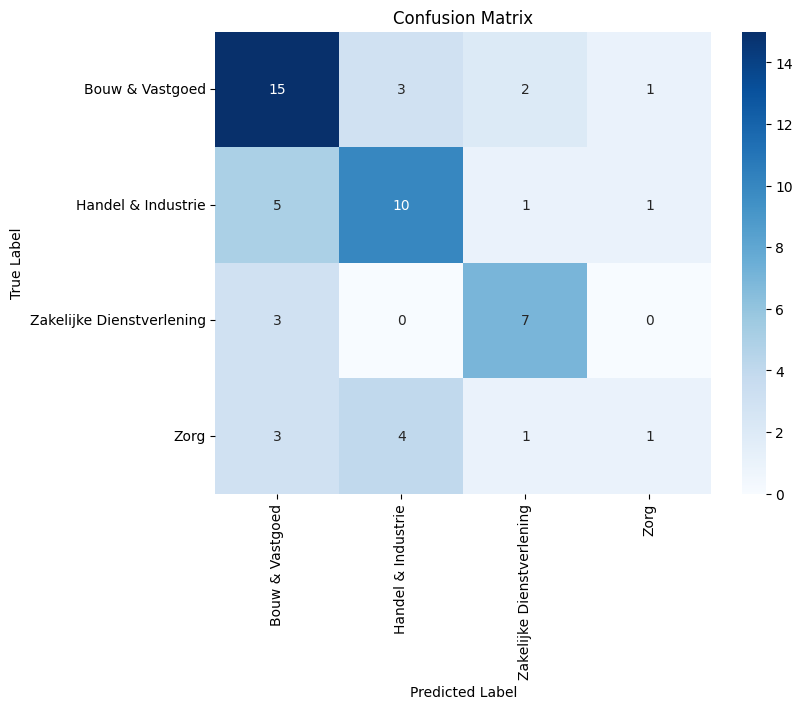

In [110]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Support Vector Machine

In [111]:
# Tune the SVM hyperparameters using the validation set
best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_tfidf, y_train)
        val_score = classifier.score(X_val_tfidf, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_tfidf, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_tfidf)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Kernel: linear, C: 0.1, Validation Score: 0.375
Kernel: linear, C: 1, Validation Score: 0.8035714285714286
Kernel: linear, C: 10, Validation Score: 0.7678571428571429
Kernel: rbf, C: 0.1, Validation Score: 0.375
Kernel: rbf, C: 1, Validation Score: 0.6785714285714286
Kernel: rbf, C: 10, Validation Score: 0.7142857142857143
Kernel: poly, C: 0.1, Validation Score: 0.375
Kernel: poly, C: 1, Validation Score: 0.6071428571428571
Kernel: poly, C: 10, Validation Score: 0.6428571428571429

Best Kernel: linear, Best C: 1, Best Validation Score: 0.8035714285714286

Test Accuracy: 0.7719298245614035

Test Classification Report:
                            precision    recall  f1-score   support

          Bouw & Vastgoed       0.89      0.76      0.82        21
       Handel & Industrie       0.74      0.82      0.78        17
Zakelijke Dienstverlening       0.62      0.80      0.70        10
                     Zorg       0.86      0.67      0.75         9

                 accuracy            

Now we show the accuracy per class and visualize them as a confusion matrix

In [112]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.7619
Class 'Handel & Industrie' Accuracy: 0.8235
Class 'Zakelijke Dienstverlening' Accuracy: 0.8000
Class 'Zorg' Accuracy: 0.6667


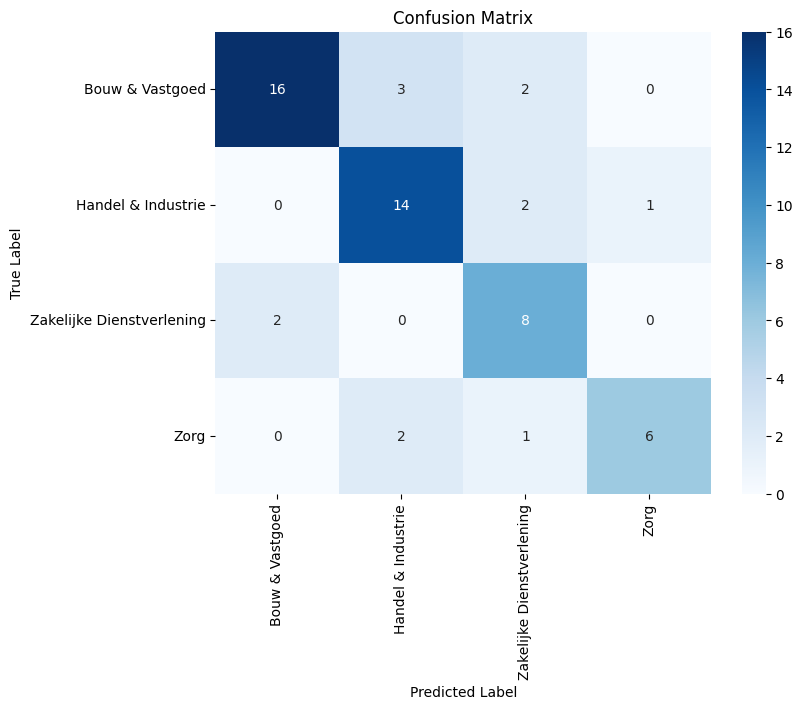

In [113]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Naive Bayes

In [114]:
# Tune the Naive Bayes hyperparameters using the validation set
best_alpha = None
best_fit_prior = None
best_score = float('-inf')

# Test different hyperparameter values
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fit_prior_values = [True, False]

for fit_prior_value in fit_prior_values:
    for alpha in alpha_values:
        classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
        classifier.fit(X_train_tfidf, y_train)
        val_score = classifier.score(X_val_tfidf, y_val)
        print(f"Alpha: {alpha}, fit_prior: {fit_prior_value}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_alpha = alpha
            best_fit_prior = fit_prior_value

print(f"\nBest alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best Validation Score: {best_score}")

# Train the final model using the best alpha and fit_prior
final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
final_classifier.fit(X_train_tfidf, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_tfidf)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Alpha: 0.01, fit_prior: True, Validation Score: 0.7857142857142857
Alpha: 0.1, fit_prior: True, Validation Score: 0.8035714285714286
Alpha: 0.5, fit_prior: True, Validation Score: 0.7142857142857143
Alpha: 1.0, fit_prior: True, Validation Score: 0.6607142857142857
Alpha: 2.0, fit_prior: True, Validation Score: 0.6071428571428571
Alpha: 5.0, fit_prior: True, Validation Score: 0.5535714285714286
Alpha: 10.0, fit_prior: True, Validation Score: 0.5178571428571429
Alpha: 0.01, fit_prior: False, Validation Score: 0.8035714285714286
Alpha: 0.1, fit_prior: False, Validation Score: 0.7857142857142857
Alpha: 0.5, fit_prior: False, Validation Score: 0.8035714285714286
Alpha: 1.0, fit_prior: False, Validation Score: 0.7857142857142857
Alpha: 2.0, fit_prior: False, Validation Score: 0.7321428571428571
Alpha: 5.0, fit_prior: False, Validation Score: 0.5535714285714286
Alpha: 10.0, fit_prior: False, Validation Score: 0.5178571428571429

Best alpha: 0.1, Best fit_prior: True, Best Validation Score: 0.

Now we show the accuracy per class and visualize them as a confusion matrix

In [115]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.6667
Class 'Handel & Industrie' Accuracy: 0.8235
Class 'Zakelijke Dienstverlening' Accuracy: 1.0000
Class 'Zorg' Accuracy: 0.7778


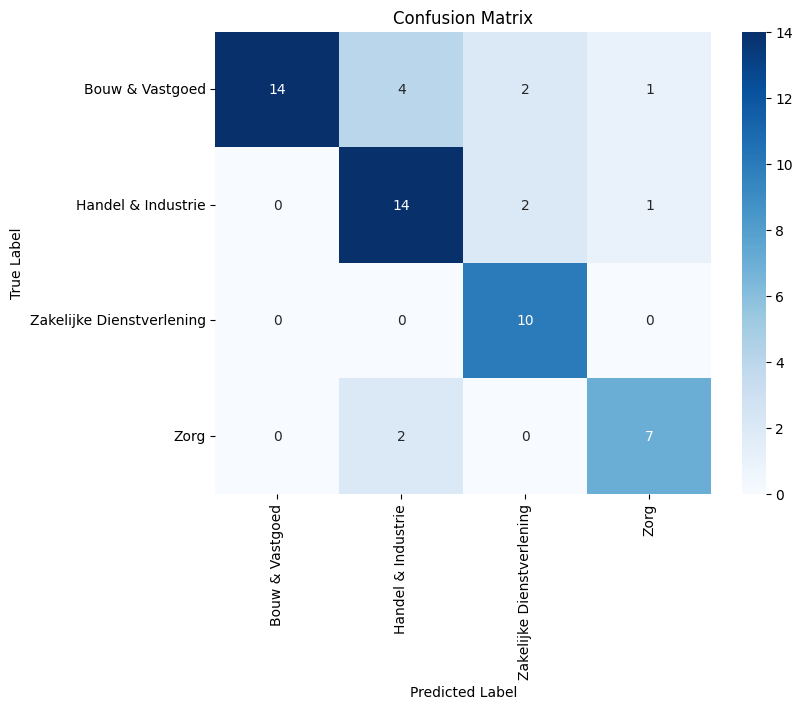

In [116]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Leave-one-out cross validation

In [117]:
# Extract features and labels
X = df_clean['text']  # Feature: text column
y = df_clean['group']  # Label: group column

# Split the data into training (85%) and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Hyperparameter tuning with LOO-CV
best_alpha = None
best_fit_prior = None
best_score = float('-inf')

# Define hyperparameter values
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fit_prior_values = [True, False]

# Try different hyperparameter combinations
for fit_prior_value in fit_prior_values:
    for alpha in alpha_values:
        scores = []
        
        for train_index, val_index in loo.split(X_train_tfidf):
            X_train_cv, X_val = X_train_tfidf[train_index], X_train_tfidf[val_index]
            y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            
            classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
            classifier.fit(X_train_cv, y_train_cv)
            
            y_pred = classifier.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
        
        mean_score = np.mean(scores)
        print(f"Alpha: {alpha}, fit_prior: {fit_prior_value}, LOO-CV Score: {mean_score}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha
            best_fit_prior = fit_prior_value

print(f"\nBest alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best LOO-CV Score: {best_score}")

# Train the final model using the best hyperparameters
final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
final_classifier.fit(X_train_tfidf, y_train)

# Evaluate on the test set
y_pred = final_classifier.predict(X_test_tfidf)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

Alpha: 0.01, fit_prior: True, LOO-CV Score: 0.7255520504731862
Alpha: 0.1, fit_prior: True, LOO-CV Score: 0.7255520504731862
Alpha: 0.5, fit_prior: True, LOO-CV Score: 0.6498422712933754
Alpha: 1.0, fit_prior: True, LOO-CV Score: 0.5709779179810726
Alpha: 2.0, fit_prior: True, LOO-CV Score: 0.5394321766561514
Alpha: 5.0, fit_prior: True, LOO-CV Score: 0.5362776025236593
Alpha: 10.0, fit_prior: True, LOO-CV Score: 0.5173501577287066
Alpha: 0.01, fit_prior: False, LOO-CV Score: 0.7066246056782335
Alpha: 0.1, fit_prior: False, LOO-CV Score: 0.7192429022082019
Alpha: 0.5, fit_prior: False, LOO-CV Score: 0.7097791798107256
Alpha: 1.0, fit_prior: False, LOO-CV Score: 0.6971608832807571
Alpha: 2.0, fit_prior: False, LOO-CV Score: 0.6593059936908517
Alpha: 5.0, fit_prior: False, LOO-CV Score: 0.5930599369085173
Alpha: 10.0, fit_prior: False, LOO-CV Score: 0.5362776025236593

Best alpha: 0.01, Best fit_prior: True, Best LOO-CV Score: 0.7255520504731862

Test Accuracy: 0.7368421052631579

Test C

In [118]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.7083
Class 'Handel & Industrie' Accuracy: 0.8824
Class 'Zakelijke Dienstverlening' Accuracy: 0.6250
Class 'Zorg' Accuracy: 0.6250


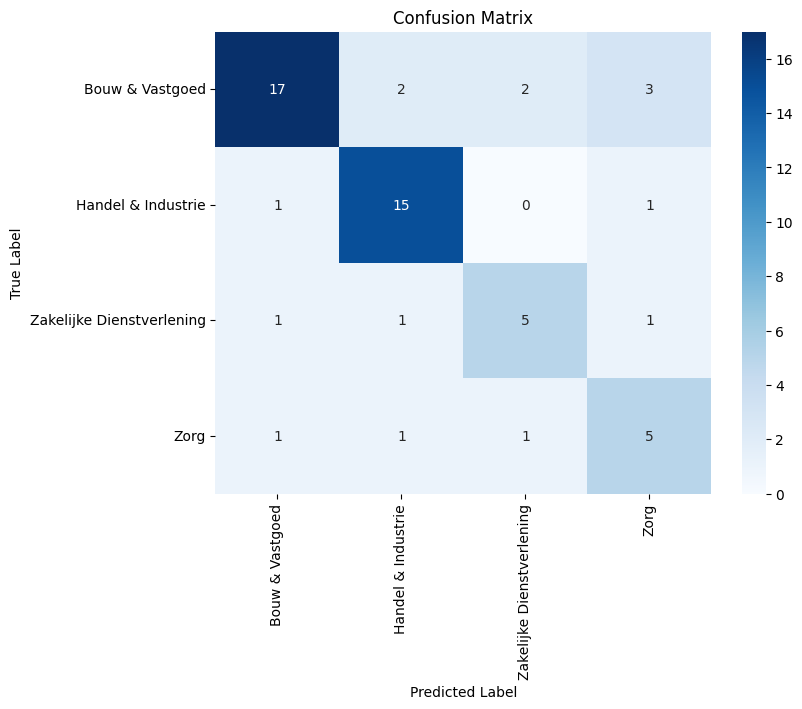

In [119]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [120]:
# This leads to worse performance. Likely since Leave-one-out cross validation tends to create High-Variance Models.
# Instead, I will use stratified K-fold cross validation. K will be treated as a hyperparameter.

In [121]:
# Extract features and labels
X = df_clean['text']  # Feature: text column
y = df_clean['group']  # Label: group column

# Split the data into training (85%) and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter tuning with Stratified K-Fold CV
best_alpha = None
best_fit_prior = None
best_k = None
best_score = float('-inf')

# Define hyperparameter values
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fit_prior_values = [True, False]
k_values = [2, 3, 5, 10, 20]  # Different values for K in StratifiedKFold

# Try different hyperparameter combinations
for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    for fit_prior_value in fit_prior_values:
        for alpha in alpha_values:
            scores = []
            
            for train_index, val_index in skf.split(X_train_tfidf, y_train):
                X_train_cv, X_val = X_train_tfidf[train_index], X_train_tfidf[val_index]
                y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
                
                classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                classifier.fit(X_train_cv, y_train_cv)
                
                y_pred = classifier.predict(X_val)
                scores.append(accuracy_score(y_val, y_pred))
            
            mean_score = np.mean(scores)
            print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, StratifiedKFold Score: {mean_score}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_alpha = alpha
                best_fit_prior = fit_prior_value
                best_k = k

print(f"\nBest K: {best_k}, Best alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best StratifiedKFold Score: {best_score}")

# Train the final model using the best hyperparameters
final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
final_classifier.fit(X_train_tfidf, y_train)

# Evaluate on the test set
y_pred = final_classifier.predict(X_test_tfidf)
y_pred_prob = final_classifier.predict_proba(X_test_tfidf)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

K: 2, Alpha: 0.01, fit_prior: True, StratifiedKFold Score: 0.7066117347344956
K: 2, Alpha: 0.1, fit_prior: True, StratifiedKFold Score: 0.7065918318605207
K: 2, Alpha: 0.5, fit_prior: True, StratifiedKFold Score: 0.5900007961149589
K: 2, Alpha: 1.0, fit_prior: True, StratifiedKFold Score: 0.5331382851683784
K: 2, Alpha: 2.0, fit_prior: True, StratifiedKFold Score: 0.5237242257782024
K: 2, Alpha: 5.0, fit_prior: True, StratifiedKFold Score: 0.5143698750099515
K: 2, Alpha: 10.0, fit_prior: True, StratifiedKFold Score: 0.4671602579412467
K: 2, Alpha: 0.01, fit_prior: False, StratifiedKFold Score: 0.6497691266618899
K: 2, Alpha: 0.1, fit_prior: False, StratifiedKFold Score: 0.7160456969986466
K: 2, Alpha: 0.5, fit_prior: False, StratifiedKFold Score: 0.7034471777724703
K: 2, Alpha: 1.0, fit_prior: False, StratifiedKFold Score: 0.6782302364461428
K: 2, Alpha: 2.0, fit_prior: False, StratifiedKFold Score: 0.6214672398694372
K: 2, Alpha: 5.0, fit_prior: False, StratifiedKFold Score: 0.5456969

In [122]:
y_pred_prob

for row in y_pred_prob:
    formatted_row = ["{:.4f}".format(val) for val in row]
    print(formatted_row)

['0.7048', '0.0439', '0.2053', '0.0460']
['0.1262', '0.1001', '0.0958', '0.6779']
['0.9650', '0.0156', '0.0133', '0.0061']
['0.0064', '0.9876', '0.0046', '0.0013']
['0.0240', '0.3774', '0.5944', '0.0042']
['0.1573', '0.4642', '0.1391', '0.2394']
['0.0246', '0.0337', '0.9304', '0.0113']
['0.0236', '0.9448', '0.0226', '0.0089']
['0.2400', '0.4353', '0.2215', '0.1032']
['0.0286', '0.0410', '0.9169', '0.0135']
['0.8269', '0.1148', '0.0307', '0.0276']
['0.0240', '0.3774', '0.5944', '0.0042']
['0.2307', '0.3196', '0.2348', '0.2150']
['0.1341', '0.6652', '0.0908', '0.1100']
['0.1666', '0.2006', '0.6138', '0.0190']
['0.0577', '0.7708', '0.1433', '0.0282']
['0.0207', '0.9388', '0.0278', '0.0127']
['0.7137', '0.1668', '0.0905', '0.0290']
['0.0868', '0.5927', '0.2436', '0.0769']
['0.2121', '0.3053', '0.4110', '0.0717']
['0.0243', '0.9305', '0.0378', '0.0075']
['0.9618', '0.0190', '0.0101', '0.0092']
['0.0445', '0.8784', '0.0444', '0.0327']
['0.0874', '0.1719', '0.1220', '0.6187']
['0.7873', '0.09

In [123]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (assuming they are in the same order as in y_train or y_test)
class_names = np.unique(y_test)  # This will give you the unique class labels

# Calculate per-class accuracy: TP / (TP + FN)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class along with its name
for i, acc in enumerate(class_accuracies):
    print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

Class 'Bouw & Vastgoed' Accuracy: 0.8421
Class 'Handel & Industrie' Accuracy: 0.7647
Class 'Zakelijke Dienstverlening' Accuracy: 0.5385
Class 'Zorg' Accuracy: 0.6250


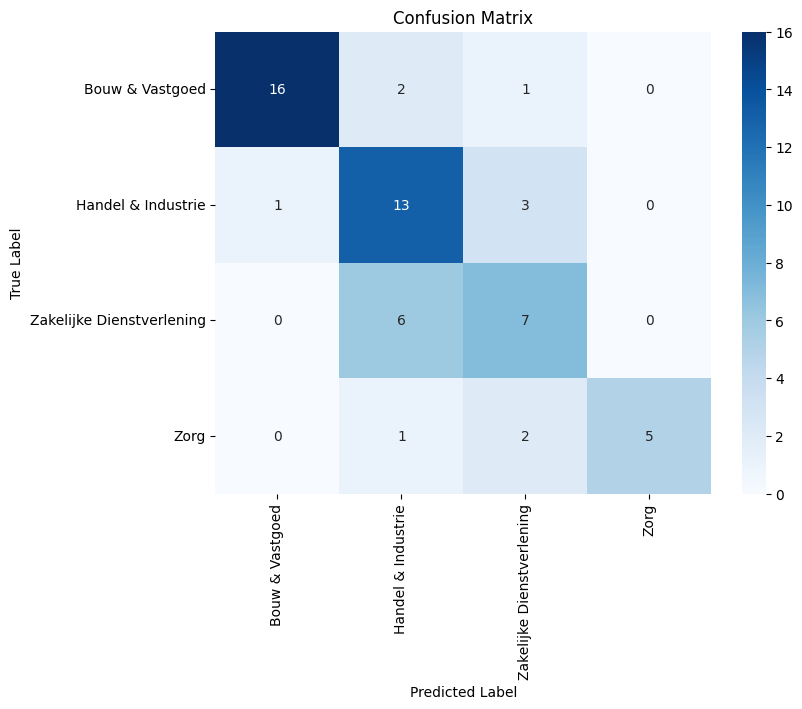

In [124]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names (from y_test)
class_names = np.unique(y_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [125]:
#Note, need to ensure TF-IDF vectorization happens within each fold to prevent leakage.

# TF-IDF vectorization within folds to avoid data leakage

Currently, vectorizations occurs over the full training set. <br>
However, we train K models, 1 for each fold. <br>
This means that for each fold, vectorizations should occur for the training data for that specific fold. <br>
This avoids data leakage from our validation set to our training set. <br>
Note that this is not strictly needed (since not separately within each fold is usually acceptable), but it should slightly improve performance at the cost of additional runtime.

In [126]:
# Assume df_clean is already defined with 'text' and 'group' columns
X = df_clean['text']  # Feature: text column
y = df_clean['group']  # Label: group column

# Split the data into training (85%) and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Hyperparameter tuning with Stratified K-Fold CV
best_alpha = None
best_fit_prior = None
best_k = None
best_score = float('-inf')

# Define hyperparameter values
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
fit_prior_values = [True, False]
k_values = [2, 3, 5, 10, 20]  # Different values for K in StratifiedKFold

# Try different hyperparameter combinations
for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    for fit_prior_value in fit_prior_values:
        for alpha in alpha_values:
            scores = []
            
            for train_index, val_index in skf.split(X_train, y_train):
                # Split the raw text data for the current fold
                X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                
                # Vectorize within the fold: fit on training fold, transform validation fold
                vectorizer = TfidfVectorizer(max_features=10000)
                X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                X_val_fold_tfidf = vectorizer.transform(X_val_fold)
                
                # Initialize and train the classifier
                classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                classifier.fit(X_train_fold_tfidf, y_train_fold)
                
                # Validate the model
                y_pred = classifier.predict(X_val_fold_tfidf)
                scores.append(accuracy_score(y_val_fold, y_pred))
            
            mean_score = np.mean(scores)
            print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, StratifiedKFold Score: {mean_score}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_alpha = alpha
                best_fit_prior = fit_prior_value
                best_k = k

print(f"\nBest K: {best_k}, Best alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best StratifiedKFold Score: {best_score}")

# Final model training on the entire training set using the best hyperparameters
# Here, we fit the vectorizer on the full training set
final_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = final_vectorizer.fit_transform(X_train)
final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
final_classifier.fit(X_train_tfidf, y_train)

# Transform the test set using the vectorizer fitted on the entire training set
X_test_tfidf = final_vectorizer.transform(X_test)
y_pred = final_classifier.predict(X_test_tfidf)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

K: 2, Alpha: 0.01, fit_prior: True, StratifiedKFold Score: 0.7223151023007722
K: 2, Alpha: 0.1, fit_prior: True, StratifiedKFold Score: 0.690828755672319
K: 2, Alpha: 0.5, fit_prior: True, StratifiedKFold Score: 0.6057638723031606
K: 2, Alpha: 1.0, fit_prior: True, StratifiedKFold Score: 0.5520659183186052
K: 2, Alpha: 2.0, fit_prior: True, StratifiedKFold Score: 0.5363227450043786
K: 2, Alpha: 5.0, fit_prior: True, StratifiedKFold Score: 0.5237640315261524
K: 2, Alpha: 10.0, fit_prior: True, StratifiedKFold Score: 0.49548204760767456
K: 2, Alpha: 0.01, fit_prior: False, StratifiedKFold Score: 0.700242815062495
K: 2, Alpha: 0.1, fit_prior: False, StratifiedKFold Score: 0.7096966802006209
K: 2, Alpha: 0.5, fit_prior: False, StratifiedKFold Score: 0.70030252368442
K: 2, Alpha: 1.0, fit_prior: False, StratifiedKFold Score: 0.6656516200939415
K: 2, Alpha: 2.0, fit_prior: False, StratifiedKFold Score: 0.6214473369954621
K: 2, Alpha: 5.0, fit_prior: False, StratifiedKFold Score: 0.5520261125

# Turning model tuning into function

Since the process of tuning a classifier tends to not change much, we create a function for every type of classifier so that we can tune them without needing to re-write the code every time.

In [127]:
def tune_random_forest(df: pd.DataFrame,
                       testing_ratio: float = 0.15, 
                       vectorization_within_folds: bool = False,
                       k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the Random Forest using stratified K-fold cross validation
    best_depth = None
    best_score = 0
    depth_values = [5, 10, 15, 20, 25, None]  # Different depths to test
    # depth_values = [5, 10]  # For faster tests
    
    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    if not vectorization_within_folds:
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for depth in depth_values:
                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_tfidf, y_train)
                y_pred = classifier.predict(X_val_tfidf)
                mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                print(f"K: {k}, Depth: {depth}, Validation Accuracy: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_depth = depth
                    best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
        
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for depth in depth_values:
            scores = []

            if vectorization_within_folds:
                for train_index, val_index in skf.split(X_train, y_train):
                    # Split the raw text data for the current fold
                    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                vectorizer = TfidfVectorizer(max_features=10000)
                X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                X_val_fold_tfidf = vectorizer.transform(X_val_fold)

                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_fold_tfidf, y_train_fold)
                y_pred = classifier.predict(X_val_fold_tfidf)

            if not vectorization_within_folds:
                for train_index, val_index in skf.split(X_train_tfidf, y_train):
                    X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                
                classifier = RandomForestClassifier(max_depth=depth, random_state=42)
                classifier.fit(X_train_fold, y_train_fold)
                y_pred = classifier.predict(X_val_fold)
                    
            scores.append(accuracy_score(y_val_fold, y_pred))
            
            mean_score = np.mean(scores)
            print(f"K: {k}, Depth: {depth}, StratifiedKFold Score: {mean_score}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_depth = depth
                best_k = k
    
    print(f"\nBest K: {best_k}, Best depth: {best_depth}, Best StratifiedKFold Score: {best_score}")
    
    # Train the final model using the best hyperparameters
    if vectorization_within_folds: # X_train_tfidf has yet to be calculated in this case
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
    final_classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    # y_pred_prob = final_classifier.predict_proba(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_depth, y_pred

In [128]:
def tune_SVM(df: pd.DataFrame,
             testing_ratio: float = 0.15, 
             vectorization_within_folds: bool = False,
             k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the SVM classifier using stratified K-fold cross validation
    best_kernel = None
    best_C = None
    best_score = 0
    
    kernels = ['linear', 'rbf', 'poly']
    C_values = [0.1, 1, 10]    

    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    if not vectorization_within_folds:
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for C in C_values:
                for kernel in kernels:
                    classifier = SVC(kernel=kernel, C=C, random_state=42)
                    classifier.fit(X_train_tfidf, y_train)
                    y_pred = classifier.predict(X_val_tfidf)
                    mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                    print(f"K: {k}, C: {C}, Kernel: {kernel}, Validation Accuracy: {mean_score}")
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_C = C
                        best_kernel = kernel
                        best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
            
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for C in C_values:
            for kernel in kernels:
                scores = []
    
                if vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train, y_train):
                        # Split the raw text data for the current fold
                        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
                    vectorizer = TfidfVectorizer(max_features=10000)
                    X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                    X_val_fold_tfidf = vectorizer.transform(X_val_fold)
    
                    classifier = SVC(kernel=kernel, C=C, random_state=42)
                    classifier.fit(X_train_fold_tfidf, y_train_fold)
                    y_pred = classifier.predict(X_val_fold_tfidf)
    
                if not vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train_tfidf, y_train):
                        X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                    
                    classifier = SVC(kernel=kernel, C=C, random_state=42)
                    classifier.fit(X_train_fold, y_train_fold)
                    y_pred = classifier.predict(X_val_fold)
                        
                scores.append(accuracy_score(y_val_fold, y_pred))
                
                mean_score = np.mean(scores)
                print(f"K: {k}, C: {C}, Kernel: {kernel}, StratifiedKFold Score: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_C = C
                    best_kernel = kernel
                    best_k = k
    
    print(f"\nBest K: {best_k}, Best C: {best_C}, Best kernel: {best_kernel}, Best StratifiedKFold Score: {best_score}")
    
    # Train the final model using the best hyperparameters
    if vectorization_within_folds: # X_train_tfidf has yet to be calculated in this case
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
    final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    # y_pred_prob = final_classifier.predict_proba(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_depth, y_pred

In [129]:
def tune_naive_bayes(df: pd.DataFrame,
                     testing_ratio: float = 0.15, 
                     vectorization_within_folds: bool = False,
                     k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    # Tune the hyperparameters of the SVM classifier using stratified K-fold cross validation
    best_alpha = None
    best_fit_prior = None
    best_score = 0
    
    alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    fit_prior_values = [True, False]  

    # Extract features and labels
    X = df['text']  # Feature: text column
    y = df['group']  # Label: group column
    
    # Split the data into training (85%) and test (15%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    if not vectorization_within_folds:
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
    
    # Try different hyperparameter combinations
    for k in k_values:
        
        if k == 1: # If k=1, we use standard hold-out cross-validation
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=testing_ratio*2, random_state=42) # testing_ratio is multiplied by 2 since it is split into validation and test sets after
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
            
            vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_val_tfidf = vectorizer.transform(X_val)
            X_test_tfidf = vectorizer.transform(X_test)
            
            for alpha in alpha_values:
                for fit_prior_value in fit_prior_values:
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_tfidf, y_train)
                    y_pred = classifier.predict(X_val_tfidf)
                    mean_score = accuracy_score(y_val, y_pred)  # Validation accuracy directly
                    print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, Validation Accuracy: {mean_score}")
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_alpha = alpha
                        best_fit_prior = fit_prior_value
                        best_k = k
                        
            # Reset X_train, X_test, X_test_tfidf, y_train and y_test after they were changed for the hold-out cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            continue # Skip the StratifiedKFold part for K=1
            
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for alpha in alpha_values:
            for fit_prior_value in fit_prior_values:
                scores = []
    
                if vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train, y_train):
                        # Split the raw text data for the current fold
                        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
                    vectorizer = TfidfVectorizer(max_features=10000)
                    X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold)
                    X_val_fold_tfidf = vectorizer.transform(X_val_fold)
    
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_fold_tfidf, y_train_fold)
                    y_pred = classifier.predict(X_val_fold_tfidf)
    
                if not vectorization_within_folds:
                    for train_index, val_index in skf.split(X_train_tfidf, y_train):
                        X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                    
                    classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior_value)
                    classifier.fit(X_train_fold, y_train_fold)
                    y_pred = classifier.predict(X_val_fold)
                        
                scores.append(accuracy_score(y_val_fold, y_pred))
                
                mean_score = np.mean(scores)
                print(f"K: {k}, Alpha: {alpha}, fit_prior: {fit_prior_value}, StratifiedKFold Score: {mean_score}")
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_alpha = alpha
                    best_fit_prior = fit_prior_value
                    best_k = k
    
    print(f"\nBest K: {best_k}, Best alpha: {best_alpha}, Best fit_prior: {best_fit_prior}, Best StratifiedKFold Score: {best_score}")
    
    # Train the final model using the best hyperparameters
    if vectorization_within_folds: # X_train_tfidf has yet to be calculated in this case
        vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
    final_classifier = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
    final_classifier.fit(X_train_tfidf, y_train)
    
    # Evaluate on the test set
    y_pred = final_classifier.predict(X_test_tfidf)
    # y_pred_prob = final_classifier.predict_proba(X_test_tfidf)
    
    print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
    print("\nTest Classification Report:\n", classification_report(y_test, y_pred))
    
    return final_classifier, best_k, best_depth, y_pred

# Overarching Model Selection Function

Expected parameter values: <br>
> - _classifier_: Selects the type of classifier from amongst the following: ["SVM", "NB", "RF"].
> - _testing_ratio_: The ratio of the data that is reserved for testing. Any floating point in the inclusive interval [0, 1].
> > Note that if $k=1$, the size of the validation set is assumed to be equal to the size of the testing set, specified by _testing_ratio_.
> - _vectorization_within_folds_: Would you like to vectorize each individual fold rather than vectorizing the entire training set once? [True, False].
> - _show_class_accuracy_: Would you like the accuracy per class to be displayed? [True, False].
> - _show_confusion_matrix_: Would you like the resulting confusion matrix to be displayed? [True, False].
> - _k_values_: All values of k which are tested for stratified k-fold cross validation. Any list containing only positive integers.

In [130]:
def train_model(df: pd.DataFrame,
                model_type: str = "SVM", 
                testing_ratio: float = 0.15, 
                vectorization_within_folds: bool = False, 
                show_class_accuracy: bool = True, 
                show_confusion_matrix: bool = True,
                k_values: list = [2, 3, 5, 10, 20]):
    """..."""

    print(f"Tuning {model_type} classifier with a train/test split of {1-testing_ratio}/{testing_ratio} \n")
    
    #Raise appropriate error message in case of a faulty parameter value
    if not isinstance(df, pd.DataFrame):
        raise ValueError(f"Invalid input data. Please ensure df is a Pandas DataFrame")
    if model_type not in ["SVM", "NB", "RF"]:
        raise ValueError(f"Invalid model_type. Choose from {'SVM', 'NB', 'RF'}")
    if testing_ratio < 0 or testing_ratio > 1:
        raise ValueError(f"Invalid testing ratio. Choose a value in the inclusive interval [0,1]")
    if type(vectorization_within_folds) != bool:
        raise ValueError(f"Invalid vectorization_within_folds value. Please ensure vectorization_within_folds is boolean")
    if type(show_class_accuracy) != bool:
        raise ValueError(f"Invalid show_class_accuracy value. Please ensure show_class_accuracy is boolean")
    if type(show_confusion_matrix) != bool:
        raise ValueError(f"Invalid show_confusion_matrix value. Please ensure show_confusion_matrix is boolean")
    if not all(isinstance(x, int) and x > 0 for x in k_values):
        raise ValueError(f"Invalid k_values. Please ensure all entries in k_values are positive integers")
    if 1 in k_values and vectorization_within_folds:
        raise ValueError(f"If k_values contains 1, vectorization_within_folds must be False since k=1 implies standard hold-out cross-validation, for which vectorization_within_folds must be False")

    model_mapping = {"SVM": SVC, "NB": MultinomialNB , "RF": RandomForestClassifier}
    ModelClass = model_mapping[model_type]
    
    #Best classifier performance and number of stratified folds so far
    best_score = 0
    best_k = None

    #RF hyperparameters:
    best_depth = None
    depth_values = [5, 10, 15, 20, 25, None]

    #SVM hyperparameters:
    best_kernel = None
    best_C = None
    kernel_values = ['linear', 'rbf', 'poly']
    C_values = [0.1, 1, 10]

    #NB hyperparameters:
    best_alpha = None
    best_fit_prior = None
    alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    fit_prior_values = [True, False]
    
    if model_type == "SVM":
        results = tune_SVM(df=df, testing_ratio=testing_ratio, vectorization_within_folds=vectorization_within_folds, k_values=k_values)
        classifier, y_pred = results[0], results[3]

    if model_type == "NB":
        results = tune_naive_bayes(df=df, testing_ratio=testing_ratio, vectorization_within_folds=vectorization_within_folds, k_values=k_values)
        classifier, y_pred = results[0], results[3]

    if model_type == "RF":
        results = tune_random_forest(df=df, testing_ratio=testing_ratio, vectorization_within_folds=vectorization_within_folds, k_values=k_values)
        classifier, y_pred = results[0], results[3]
    
    if show_class_accuracy:
        cm = confusion_matrix(y_test, y_pred)
        
        # Class names (assuming they are in the same order as in y_train or y_test)
        class_names = np.unique(y_test)  # This will give you the unique class labels
        
        # Calculate per-class accuracy: TP / (TP + FN)
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        
        # Print the accuracy for each class along with its name
        for i, acc in enumerate(class_accuracies):
            print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

    if show_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred)
        class_names = np.unique(y_test)
        
        # Plotting the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
        
        # Label the axes
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        # Display the plot
        plt.show()

# Testing Function

The code below serves only to test the _train_model_ function and to detect and remove bugs. <br>
The specific parameter values hold no significance.

Tuning RF classifier with a train/test split of 0.85/0.15 

K: 2, Depth: 5, StratifiedKFold Score: 0.4430379746835443
K: 2, Depth: 10, StratifiedKFold Score: 0.4620253164556962
K: 2, Depth: 15, StratifiedKFold Score: 0.4620253164556962
K: 2, Depth: 20, StratifiedKFold Score: 0.47468354430379744
K: 2, Depth: 25, StratifiedKFold Score: 0.47468354430379744
K: 2, Depth: None, StratifiedKFold Score: 0.4873417721518987
K: 3, Depth: 5, StratifiedKFold Score: 0.4095238095238095
K: 3, Depth: 10, StratifiedKFold Score: 0.49523809523809526
K: 3, Depth: 15, StratifiedKFold Score: 0.47619047619047616
K: 3, Depth: 20, StratifiedKFold Score: 0.4857142857142857
K: 3, Depth: 25, StratifiedKFold Score: 0.4666666666666667
K: 3, Depth: None, StratifiedKFold Score: 0.4857142857142857
K: 5, Depth: 5, StratifiedKFold Score: 0.5079365079365079
K: 5, Depth: 10, StratifiedKFold Score: 0.49206349206349204
K: 5, Depth: 15, StratifiedKFold Score: 0.49206349206349204
K: 5, Depth: 20, StratifiedKFold Score: 0.492063

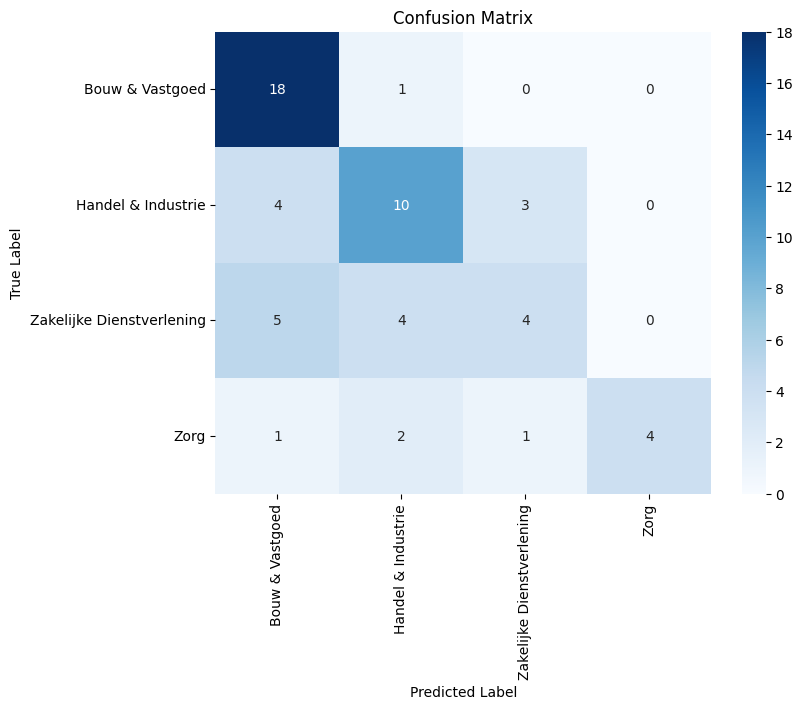

In [131]:
train_model(df=df_clean,
            model_type = "RF", 
            testing_ratio = 0.15, 
            vectorization_within_folds = False, 
            show_class_accuracy = True, 
            show_confusion_matrix = True)

Tuning SVM classifier with a train/test split of 0.85/0.15 

K: 1, C: 0.1, Kernel: linear, Validation Accuracy: 0.375
K: 1, C: 0.1, Kernel: rbf, Validation Accuracy: 0.375
K: 1, C: 0.1, Kernel: poly, Validation Accuracy: 0.375
K: 1, C: 1, Kernel: linear, Validation Accuracy: 0.8035714285714286
K: 1, C: 1, Kernel: rbf, Validation Accuracy: 0.6785714285714286
K: 1, C: 1, Kernel: poly, Validation Accuracy: 0.6071428571428571
K: 1, C: 10, Kernel: linear, Validation Accuracy: 0.7678571428571429
K: 1, C: 10, Kernel: rbf, Validation Accuracy: 0.7142857142857143
K: 1, C: 10, Kernel: poly, Validation Accuracy: 0.6428571428571429
K: 2, C: 0.1, Kernel: linear, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 0.1, Kernel: rbf, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 0.1, Kernel: poly, StratifiedKFold Score: 0.33544303797468356
K: 2, C: 1, Kernel: linear, StratifiedKFold Score: 0.6455696202531646
K: 2, C: 1, Kernel: rbf, StratifiedKFold Score: 0.5189873417721519
K: 2, C: 1, Kernel: p

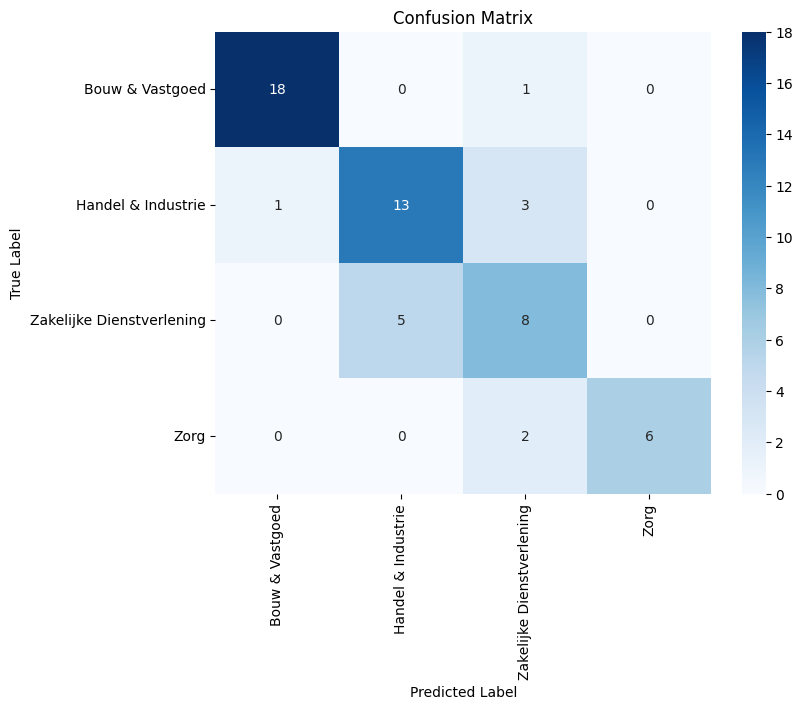

In [132]:
train_model(df=df_clean,
            model_type = "SVM", 
            testing_ratio = 0.15, 
            vectorization_within_folds = False, 
            show_class_accuracy = True, 
            show_confusion_matrix = True,
            k_values = [1,2,5,10,20])

Tuning NB classifier with a train/test split of 0.8/0.2 

K: 2, Alpha: 0.01, fit_prior: True, StratifiedKFold Score: 0.6962025316455697
K: 2, Alpha: 0.01, fit_prior: False, StratifiedKFold Score: 0.6772151898734177
K: 2, Alpha: 0.1, fit_prior: True, StratifiedKFold Score: 0.6835443037974683
K: 2, Alpha: 0.1, fit_prior: False, StratifiedKFold Score: 0.6835443037974683
K: 2, Alpha: 0.5, fit_prior: True, StratifiedKFold Score: 0.6329113924050633
K: 2, Alpha: 0.5, fit_prior: False, StratifiedKFold Score: 0.6962025316455697
K: 2, Alpha: 1.0, fit_prior: True, StratifiedKFold Score: 0.5569620253164557
K: 2, Alpha: 1.0, fit_prior: False, StratifiedKFold Score: 0.6772151898734177
K: 2, Alpha: 2.0, fit_prior: True, StratifiedKFold Score: 0.5506329113924051
K: 2, Alpha: 2.0, fit_prior: False, StratifiedKFold Score: 0.620253164556962
K: 2, Alpha: 5.0, fit_prior: True, StratifiedKFold Score: 0.5569620253164557
K: 2, Alpha: 5.0, fit_prior: False, StratifiedKFold Score: 0.5443037974683544
K: 2, Alpha

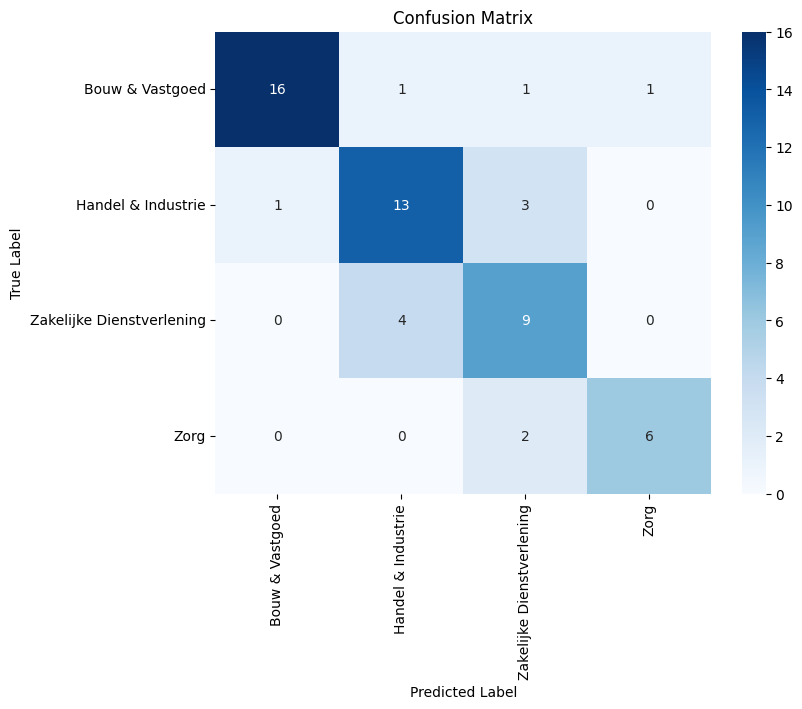

In [133]:
train_model(df=df_clean,
            model_type = "NB", 
            testing_ratio = 0.2, 
            vectorization_within_folds = True, 
            show_class_accuracy = True, 
            show_confusion_matrix = True,
           k_values = [2,12,15])

# Showing percentages per class

First for SVM classification

Now for Naive Bayes

In [134]:
#NOTE: i have noticed that test performance tends to be higher for k>1 even though the validation score would suggest that k=1 is best. 
#I think this is because stratified cross validation generalizes better.
#How do I decide on k? I can't run everything over test set, that would turn test set into 2nd validation set.

# Testing BERTje word embeddings

**NOTE**: These are just basic tests to see if the word embeddings hold potential. <br>
The option to use word embeddings should be added to the train_model function above

First we test random forests

In [135]:
# Tune the depth of the Random Forest using the validation set
best_depth = None
best_score = 0
depths = [5, 10, 15, 20, 25, None]  # Different depths to test

for depth in depths:
    classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    classifier.fit(train_embeddings, y_train_bertje)
    val_score = classifier.score(val_embeddings, y_val_bertje)
    print(f"Depth: {depth}, Validation Score: {val_score}")
    if val_score > best_score:
        best_score = val_score
        best_depth = depth

print(f"\nBest Depth: {best_depth}, Best Validation Score: {best_score}")

# Train the final model using the best depth
final_classifier = RandomForestClassifier(max_depth=best_depth, random_state=42)
final_classifier.fit(train_embeddings, y_train_bertje)

# Test the model
y_pred = final_classifier.predict(test_embeddings)
print("\nTest Accuracy:", accuracy_score(y_test_bertje, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test_bertje, y_pred))

Depth: 5, Validation Score: 0.5714285714285714
Depth: 10, Validation Score: 0.5714285714285714
Depth: 15, Validation Score: 0.5535714285714286
Depth: 20, Validation Score: 0.5535714285714286
Depth: 25, Validation Score: 0.5535714285714286
Depth: None, Validation Score: 0.5535714285714286

Best Depth: 5, Best Validation Score: 0.5714285714285714

Test Accuracy: 0.49122807017543857

Test Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.76      0.71        21
           1       0.39      0.53      0.45        17
           2       0.33      0.30      0.32        10
           3       0.00      0.00      0.00         9

    accuracy                           0.49        57
   macro avg       0.35      0.40      0.37        57
weighted avg       0.42      0.49      0.45        57



Now we Test SVM:

In [136]:
best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(train_embeddings, y_train_bertje)
        val_score = classifier.score(val_embeddings, y_val_bertje)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(train_embeddings, y_train_bertje)

# Test the model
y_pred = final_classifier.predict(test_embeddings)
print("\nTest Accuracy:", accuracy_score(y_test_bertje, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test_bertje, y_pred))

Kernel: linear, C: 0.1, Validation Score: 0.7321428571428571
Kernel: linear, C: 1, Validation Score: 0.7321428571428571
Kernel: linear, C: 10, Validation Score: 0.7321428571428571
Kernel: rbf, C: 0.1, Validation Score: 0.375
Kernel: rbf, C: 1, Validation Score: 0.6071428571428571
Kernel: rbf, C: 10, Validation Score: 0.75
Kernel: poly, C: 0.1, Validation Score: 0.375
Kernel: poly, C: 1, Validation Score: 0.625
Kernel: poly, C: 10, Validation Score: 0.75

Best Kernel: rbf, Best C: 10, Best Validation Score: 0.75

Test Accuracy: 0.6140350877192983

Test Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62        21
           1       0.59      0.59      0.59        17
           2       0.60      0.90      0.72        10
           3       0.57      0.44      0.50         9

    accuracy                           0.61        57
   macro avg       0.61      0.63      0.61        57
weighted avg       0.62      0.61     

Now we test Naive Bayes (We test GaussianNB, since MultinomialNB does not work for continuous features)

In [137]:
best_var_smoothing = None
best_score = float('-inf')

# Test different hyperparameter values
var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7]

for var_smoothing in var_smoothing_values:
    classifier = GaussianNB(var_smoothing=var_smoothing)
    classifier.fit(train_embeddings, y_train_bertje)
    val_score = classifier.score(val_embeddings, y_val_bertje)
    print(f"Var_smoothing: {var_smoothing}, Validation Score: {val_score}")
    if val_score > best_score:
        best_score = val_score
        best_var_smoothing = var_smoothing

print(f"\nBest var_smoothing: {best_var_smoothing}, Best Validation Score: {best_score}")

# Train the final model using the best alpha and fit_prior
final_classifier = GaussianNB(var_smoothing=best_var_smoothing)
final_classifier.fit(train_embeddings, y_train_bertje)

# Test the model
y_pred = final_classifier.predict(test_embeddings)
print("\nTest Accuracy:", accuracy_score(y_test_bertje, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test_bertje, y_pred))

Var_smoothing: 1e-11, Validation Score: 0.6964285714285714
Var_smoothing: 1e-10, Validation Score: 0.6964285714285714
Var_smoothing: 1e-09, Validation Score: 0.6964285714285714
Var_smoothing: 1e-08, Validation Score: 0.6964285714285714
Var_smoothing: 1e-07, Validation Score: 0.6964285714285714

Best var_smoothing: 1e-11, Best Validation Score: 0.6964285714285714

Test Accuracy: 0.5964912280701754

Test Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        21
           1       0.82      0.53      0.64        17
           2       0.38      0.60      0.46        10
           3       0.44      0.44      0.44         9

    accuracy                           0.60        57
   macro avg       0.59      0.57      0.57        57
weighted avg       0.64      0.60      0.61        57



Surprisingly, these models all perform worse than their tf-idf counterparts. <br>
**TO DO**: Rename train_embeddings, val_embeddings, test_embeddings to X_train_bertje, X_val_bertje, X_test_bertje

**Idea**: Once pos_tags are used for classification, test and compare performance for:
> - Bag of Words <br>
> - TF-IDF <br>
> - BERTje <br>
> - mBERT (Multilingual BERT) <br>
> - RobBERT (Dutch RoBERTa model)
> - Word2Vec